In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import csv
import numpy as np
import random
import math
import tqdm

In [3]:
def get_data():
  data = []
  with open('/content/drive/MyDrive/Sem-7/SC-Lab/IBM.csv') as fin:
    reader = csv.reader(fin)
    for row in reader:
      data.append(row[1:])
  
  data = np.array(data[1:],dtype=np.float)
  return data


In [4]:
def get_training_data(data, row_choice,d) :
  data_train = []
  for i in range(d):
    data_train.append(data[row_choice[i][0],:])
  return np.array(data_train)

In [5]:
def get_normalised_data(x,n,m):
  y = np.zeros([n, m])
  mean_values = np.zeros([1,m])
  deviation = np.zeros([1,m])
  for i in range(m):
    mean_values[0][i]=np.mean(x[:,i] )
    deviation[0][i] =np.std(x[:,i] )
  
  for j in range(m):
    for i in range(n):
      y[i][j]=(x[i][j]-mean_values[0][j])/deviation[0][j]
  return y


In [6]:
def get_weights(n,m) :
  y = np.zeros( [n,m] ,dtype=int)
  for i in range(n):
    for j in range(m):
      r = random.uniform(0,1)
      if r>=0.5:
        y[i][j] = 1
  return y

In [7]:
def two2dec(x1):
  decimal = 0
  n = len(x1)
  x = x1
  
  if x[0] == 1:
    negative = 1
  else:
    negative = 0
  if negative == 1:
    x = x[1:]
    m = len(x)
    for i in range(m):
      if x[i]==0:
        x[i]=1
      else:
        x[i]=0
    i = m-1
    k=m
    while(i>=1 and x[i]==1):
      k=i
      x[i]=0
      i = i - 1
    if k-1>=1:
      x[k-1]=1
    elif k-1==0:
      x[k-1]=0

  for i in range(len(x)):
    decimal = decimal+2**(i)*x[len(x)-i-1]
  if negative == 1:
    decimal = decimal-2*decimal
  return decimal

In [8]:
def generate_weights(x,n,d,f):
  y = np.zeros([int(n/f),f],dtype = int)

  for i in range(int(n/f)):
    for j in range(f):
      a=j+(f-1)*(i-1)
      y[i][j] = two2dec(x[a])
  return y

In [23]:
def fitness(data,row_choice,data_train,data_train_norm,weight,nn,n,e):
  x = np.zeros([e,1],dtype = int)
  res = np. zeros([nn*e,1],dtype=int)
  
  for i in range(e):
    for j in range(nn):
      res[j+(nn*i)]= np.sum(weight[i][:6]*data_train_norm[j])+weight[i][6]
  for i in range(e):
    for j in range(nn):
      a = j+(nn*i)
      if res[a]>=0:
        res_sigmoid = 1
      else:
        res_sigmoid = 0
      res_real = data[row_choice[j]+1][0][1] - data_train[j][1]
      if res_real > 0:
        res_real_sigmoid = 1
      else:
        res_real_sigmoid = 0
      if res_real_sigmoid == res_sigmoid:
        x[i]=x[i]+1
  return x

In [24]:
def get_best_fitness(fit,w,e):
  x = max(fit)
  j = 1
  s = []
  for i in range(e):
    if fit[i]==x:
      s.append(w[j])
  return np.array(s)

In [25]:
def RouletteWheel(arrayInput):
  length = len(arrayInput)
  if length == 1:
    index = 1

  if min(arrayInput) !=0:
    arrayInput = 1/min(arrayInput)*arrayInput
  
  temp = 0
  tempProbs = np.zeros( [1, length])
  for i in range(length):
    tempProbs[0][i] = temp + arrayInput[i]
    temp = tempProbs[0][i]

  i = np.fix(np.random.rand(1)[0]*math.floor(tempProbs[0][length-1]))+1
             
  for j in range(length):
    if tempProbs[0][j]>=i:
      index=j
      break
  return index


In [26]:
def selection (weight, fit, n, m):
  mat = np.zeros([n,m])
  for i in range(n):
    index = RouletteWheel(fit/np.sum(fit))
    mat[i] = weight[index]
  return mat


In [27]:
def dec2twos(x, nbits) :
  nbits = nbits + 2
  x = int(x)
  a = list(np.binary_repr(x,width=nbits))
  for i in range(len(a)):
    a[i] = int(a[i])
  return a


In [28]:
def crossover(data_sel,d,e,f):
  mat_cross = np.zeros( [e, f] )
  for j in range(f):
    for i in range(0,e,2):
      x = dec2twos(data_sel[i][j],d)
      y = dec2twos(data_sel[i+1][j],d)

      CI1 = int(round(3*np.random.rand(1)[0])) + 1
      CI2 = int(round(4*np.random.rand(1)[0])) + 6

      z1 = x[:CI1] + y[CI1:CI2] + x[CI2:]
      z2 = y[:CI1] + x[CI1:CI2] + y[CI2:]

      mat_cross[i][j] = two2dec(z1)
      mat_cross[i+1][j] = two2dec(z2)
  return mat_cross


In [29]:
def mutation(data_cross, d, e, f, w_pro):
  mat_mut = data_cross
  p = 0.0253
  pm_prob = 1 - (1 - p)**((d+2)*f)
  for i in range(e):
    for j in range(f):
      x = np.random.rand(1)[0]
      y = []
      if x>pm_prob:
        y = dec2twos(data_cross[i][j],d)
        place = np.random.randint(1,11)
        if y[place] == 0:
          y[place] = 1
        else:
          y[place] = 0
        a = two2dec(y)
        mat_mut[i][j] = a
  dim_pro = w_pro.shape[0]
  for i in range(dim_pro):
    x = int(round((e-2)*np.random.rand(1)[0])+1)
    mat_mut[x] = w_pro[i]
  return mat_mut


In [30]:
cc = 700
c = 700
d = 9
e = 100
f = 7

data =  get_data()
row_choice = np.random.randint(1000,1400,(700,1)) 
data_train = get_training_data(data , row_choice, 700)
print("\nTraining Data:\n"+str(data_train[:5]))
data_train_norm = get_normalised_data(data_train, cc, f-1) # NORMALISED DATA (70, 6)
print("\nNoramlaised Data:\n "+str(data_train_norm[:5]))
weights_bin = get_weights(c,d) # BINARY WEIGHTS (700, 9)
weight = generate_weights(weights_bin,c,d,f)
print("\nInitial Population:\n" + str(weight[:5]))



Training Data:
[[7.7279999e+01 7.7279999e+01 7.6360001e+01 7.6410004e+01 4.8698437e+01
  6.3298000e+06]
 [7.6300003e+01 7.6949997e+01 7.6000000e+01 7.6510002e+01 4.8762173e+01
  4.7598000e+06]
 [9.3370003e+01 9.3580002e+01 9.2510002e+01 9.3080002e+01 5.8695450e+01
  4.5373000e+06]
 [8.3599998e+01 8.5129997e+01 8.3570000e+01 8.5129997e+01 5.3904976e+01
  4.3975000e+06]
 [9.1980003e+01 9.2589996e+01 9.1949997e+01 9.2190002e+01 5.8488277e+01
  5.0707000e+06]]

Noramlaised Data:
 [[-1.60330299 -1.69174518 -1.63431712 -1.70685033 -1.67858404  0.22923033]
 [-1.74373759 -1.73887906 -1.68529712 -1.69271951 -1.66401002 -0.35341933]
 [ 0.70241377  0.63636909  0.65269623  0.64880339  0.60735497 -0.43599229]
 [-0.6976396  -0.57053727 -0.61330393 -0.47461959 -0.48804536 -0.48787408]
 [ 0.50322511  0.49496745  0.57339352  0.52303662  0.55998234 -0.23803985]]

Initial Population:
[[-238 -144  225 -111  238   71  -78]
 [-178   24   24 -147  106  149  235]
 [ 235  198 -149 -113 -233  205  229]
 [ 229 

In [31]:
y = []
count = []
for i in tqdm.tqdm(range(100)):
  print("\nGeneration\n"+str(i+1))
  fit = fitness(data, row_choice, data_train, data_train_norm, weight, cc, c, e)
  print("\nFitness: \n" + str(fit[:5]))
  best_weight = get_best_fitness(fit,weight,e) # get best fitness value
  print("\nBest Weight: \n"+str(best_weight))
  data_sel= selection(weight,fit,e,f) # data selection
  print("\nData Selection:\n" + str(data_sel[:5]))
  data_cross = crossover(data_sel,d,e,f) # crossover
  print("\nData Crossover:\n" + str(data_cross[:5]))
  data_mut = mutation(data_cross,d,e,f, best_weight) # mutation
  print("Data Mutation:\n "+str(data_mut[:5]))
  weight = data_mut
  y.append((max(fit)/cc)*100)
  count.append( i+1 )



  0%|          | 0/100 [00:00<?, ?it/s]


Generation
1


  1%|          | 1/100 [00:01<02:17,  1.39s/it]


Fitness: 
[[351]
 [314]
 [318]
 [324]
 [321]]

Best Weight: 
[[-178   24   24 -147  106  149  235]]

Data Selection:
[[-120. -170.    8.  120.  -16. -250.   51.]
 [-120. -170.    8.  120.  -16. -250.   51.]
 [-223.   12. -176. -232. -192.   39.   94.]
 [-159.  178.   96. -226.  -41. -111. -137.]
 [ -88.  -62.  -74.  -73.   69.  126.  241.]]

Data Crossover:
[[-120. -170.    8.  120.  -16. -250.   51.]
 [-120. -170.    8.  120.  -16. -250.   51.]
 [-159.  178. -416. -226.  -44.  407.  382.]
 [-223.   12.  336. -232. -189. -479. -425.]
 [-200. -110. -166. -377.  973.  478.   17.]]
Data Mutation:
 [[-120. -170.    8.  120.  -16. -250.   51.]
 [-120. -170.  136.  120.  -16. -250.   51.]
 [-159.  178. -416. -226.  -44.  407.  382.]
 [-223.   12.  336. -232. -191. -479. -425.]
 [-200. -110. -166. -377.  973.  478.   17.]]

Generation
2


  2%|▏         | 2/100 [00:02<02:00,  1.23s/it]


Fitness: 
[[377]
 [365]
 [342]
 [371]
 [352]]

Best Weight: 
[[-120. -170.  136.  120.  -16. -250.   51.]]

Data Selection:
[[ 451.    5. -296. -137. -101.  101. -202.]
 [ 151.  128. -174.  230.   54.  192. -122.]
 [-178.   24.   24. -151.  106.  149.  235.]
 [ 231.   72. -885.   30.    6.  168.  -98.]
 [ 275.  241. -486.  -58.  -33.  789. -186.]]

Data Crossover:
[[ 407.  133. -176. -153. -201.  193. -122.]
 [ 195.    0. -294.  246.  154.  100. -202.]
 [-274.   72.    8. -483.    6.  181.  139.]
 [ 327.   24. -869.  362.  106.  136.   -2.]
 [  51.  337. -774. -202. -241.  965. -202.]]
Data Mutation:
 [[ 405.  133. -176. -153. -201.  193. -114.]
 [ 203.    0. -310.  246.  154.  100. -194.]
 [-402.   72.    8. -483.    6.  437.  139.]
 [ 327.   24. -869.  362.  106.  136.   -2.]
 [  51.  337. -774. -202. -113.  965. -202.]]

Generation
3


  3%|▎         | 3/100 [00:03<01:54,  1.18s/it]


Fitness: 
[[346]
 [353]
 [354]
 [333]
 [343]]

Best Weight: 
[[ 203.    0. -310.  246.  154.  100. -194.]]

Data Selection:
[[ -118.  -356.    49.   -44.   824.   265.   227.]
 [   19.   231.   792.  -201.   417.  -635.   199.]
 [   19.   231.   792.  -201.   417.  -635.   199.]
 [  -58.     6.   602.  -138.   414.  -411.    52.]
 [ -963. -1010.  -474.  -117.   471.   426.   193.]]

Data Crossover:
[[-494. -284.   25. -204.  928.  389.  195.]
 [ 395.  159.  816.  -41.  313. -759.  231.]
 [ 211.    7.  600. -137.  401. -923.   55.]
 [-250.  230.  794. -202.  430. -123.  196.]
 [-115. -802. -242.  -55.  423.  378.  153.]]
Data Mutation:
 [[-462. -284.   25. -203.  928.  397.  195.]
 [ 399.  159.  816. -169.  313. -759.  227.]
 [ 211.    7.  600. -153.  401. -923.   55.]
 [-250.  230.  794. -202.  430. -123.  196.]
 [-115. -802. -242.  -55.  423.  378.  153.]]

Generation
4


  4%|▍         | 4/100 [00:04<01:51,  1.16s/it]


Fitness: 
[[362]
 [331]
 [344]
 [329]
 [358]]

Best Weight: 
[[ 399.  159.  816. -169.  313. -759.  227.]]

Data Selection:
[[ 876. -585.  234.   17.  472. -106.  887.]
 [-516. -334. -340. -969.  935.  264.  265.]
 [-489.  321.  613.  293. -248. -172. -218.]
 [ 435.   57. -518. -234.  -57.   69. -124.]
 [-251. -455. -507. -739.  212.  312. -206.]]

Data Crossover:
[[  892.  -589.   170.    49.   416.  -106.   775.]
 [ -532.  -330.  -276. -1001.   991.   264.   377.]
 [  -73.   313.  1013.   789.   -64.  -956.  -122.]
 [   19.    65.  -918.  -730.  -241.   853.  -220.]
 [ -867.  -487.  -411.  -667.   444.   328.  -814.]]
Data Mutation:
 [[  892.  -589.   170.    49.   416.  -106.   775.]
 [ -596.  -330.  -276. -1001.   991.   268.   377.]
 [  -89.   313.  1013.   789.  -128.  -956.  -122.]
 [   18.    65.  -918.  -218.  -241.   853.  -220.]
 [ -867.  -487.  -411.  -667.   444.   328.  -814.]]

Generation
5


  5%|▌         | 5/100 [00:05<01:48,  1.14s/it]


Fitness: 
[[329]
 [358]
 [343]
 [362]
 [382]]

Best Weight: 
[[ -596.  -330.  -276. -1001.   991.   268.   377.]]

Data Selection:
[[ -99. -715. -159. -788.  696.  834.  -42.]
 [ 916. -123.  338.  125.  304.  -42.  647.]
 [ 993. -390.  647. -442.   32. -602. -185.]
 [  51.  139.  548. -625.  343. -219.  199.]
 [ 405.  409. -327. -421.   38.  520.  367.]]

Data Crossover:
[[ -99. -763. -687. -900.  312.  978. -378.]
 [ 916.  -75.  866.  237.  688. -186.  983.]
 [ 945. -374.  679. -498.  320. -730. -313.]
 [  99.  123.  516. -569.   55.  -91.  327.]
 [ 397.  461. -487. -445.   62.  634.  271.]]
Data Mutation:
 [[ -99. -251. -687. -900.  312.  982. -378.]
 [ 916.  -75.  866.  237.  688. -186.  983.]
 [ 945. -374.  679. -498.  320. -730. -313.]
 [  99.  123.  516. -569.   55.  -91.  327.]
 [ 397.  461. -485. -445.   62.  634.  271.]]

Generation
6


  6%|▌         | 6/100 [00:06<01:47,  1.14s/it]


Fitness: 
[[358]
 [324]
 [341]
 [337]
 [324]]

Best Weight: 
[[ 916.  -75.  866.  237.  688. -186.  983.]
 [ 916.  -75.  866.  237.  688. -186.  983.]
 [ 916.  -75.  866.  237.  688. -186.  983.]]

Data Selection:
[[ 179.   59. 1000. -249.  201. -187.  391.]
 [  27.  203.  684. -801.  311. -403.  167.]
 [-382. -550. -228. -315.  549.  118.  653.]
 [-113.  158. -454. -425.  312. -758. -797.]
 [  50.  157. -460. -121. -171.  293.  -50.]]

Data Crossover:
[[  19.  203.  680. -169.   55. -403.  423.]
 [ 187.   59. 1004. -881.  457. -187.  135.]
 [-374. -870. -200. -427.  569.  270.  741.]
 [-121.  478. -482. -313.  292. -910. -885.]
 [ 482.  125. -364. -441. -991.  423. -178.]]
Data Mutation:
 [[  19.  203.  680. -169.   55. -403.  423.]
 [ 187.   27. 1004. -881.  457. -187.  135.]
 [-373. -870. -200. -427.  569.  270.  741.]
 [-121.  478. -482. -313.  294. -910. -885.]
 [ 482.  125. -364. -441. -991.  423. -178.]]

Generation
7


  7%|▋         | 7/100 [00:08<01:46,  1.15s/it]


Fitness: 
[[339]
 [334]
 [342]
 [384]
 [357]]

Best Weight: 
[[ 187.   27. 1004. -881.  457. -187.  135.]]

Data Selection:
[[ 482.  125. -364. -441. -991.  423. -178.]
 [-446.  187. -129. -361. -235.  512. -596.]
 [ -70.  110.  770. -386.  286. -403.  284.]
 [ 807.  665. -962. -176. -735.  525.  -18.]
 [ -30.  123. -361. -441. -715.  420. -572.]]

Data Crossover:
[[   66.    61.  -132.  -361.  -751.     7.  -210.]
 [  -30.   251.  -361.  -441.  -475.   928.  -564.]
 [ -222.   158.   570.  -418.   302.  -499.   492.]
 [  959.   617.  -762.  -144.  -751.   621.  -226.]
 [  -30.   123. -1017.  -311.  -587.   164.  -700.]]
Data Mutation:
 [[   66.    61.  -132.  -361. -1007.    23.  -210.]
 [  -30.   251.  -361.  -441.  -475.   928.  -564.]
 [ -222.   158.   570.  -418.   302.  -499.   492.]
 [  959.   617.  -762.  -144.  -751.   621.  -226.]
 [  -30.   123. -1017.  -311.  -523.   164.  -700.]]

Generation
8


  8%|▊         | 8/100 [00:09<01:46,  1.16s/it]


Fitness: 
[[373]
 [352]
 [342]
 [349]
 [371]]

Best Weight: 
[[ -30.  251. -361. -441. -475.  928. -564.]]

Data Selection:
[[ 868.  505.   13.  713.  -79.  -90. -693.]
 [ 128.  129. -472. -365.  -65.  345. -210.]
 [-374.  718.  542. -954.  318. -775.   28.]
 [1009. -774.  537. -458.  416. -894. -229.]
 [ 649.  -62.   31.  -60. -204. -916. -251.]]

Data Crossover:
[[ 132.  137.   45.  657.  -71. -162. -721.]
 [ 864.  497. -504. -309.  -73.  417. -182.]
 [-270.  762.  536. -970.  418. -887.  280.]
 [ 905. -818.  543. -442.  316. -782. -481.]
 [ 185.  -22.   15. -908. -228. -660. -227.]]
Data Mutation:
 [[ 132.  137.   45.  659.  -71. -162. -721.]
 [ 865.  497. -504. -309.  -73.  417. -182.]
 [-270.  754.  536. -962.  290. -887.  280.]
 [ 905. -562.  543. -442.  316. -782. -481.]
 [ 184.  -54.   15. -908. -228. -660. -227.]]

Generation
9


  9%|▉         | 9/100 [00:10<01:45,  1.16s/it]


Fitness: 
[[367]
 [324]
 [351]
 [363]
 [355]]

Best Weight: 
[[ 865.  497. -504. -309.  -73.  417. -182.]]

Data Selection:
[[  58.  235. -254. -385. -481.  367. -226.]
 [-247. -809.  543.   86.  -26. -645.  911.]
 [ -73. -821.  415.  166. -222. -881.  455.]
 [-485.   32.  633.  807. -501. -937. -219.]
 [  35.  413. -970. -169.  308.  898.  197.]]

Data Crossover:
[[ 7.780e+02  2.110e+02 -2.540e+02 -4.170e+02 -1.000e+00  3.790e+02
  -1.140e+02]
 [-9.670e+02 -7.850e+02  5.430e+02  1.180e+02 -5.060e+02 -6.570e+02
   7.990e+02]
 [-2.290e+02 -8.610e+02  6.350e+02  1.660e+02 -5.020e+02 -9.370e+02
   2.950e+02]
 [-3.290e+02  7.200e+01  4.130e+02  8.070e+02 -2.210e+02 -8.810e+02
  -5.900e+01]
 [ 1.310e+02  4.450e+02 -1.002e+03 -2.490e+02  5.960e+02  9.460e+02
   3.030e+02]]
Data Mutation:
 [[ 7.780e+02  2.090e+02 -5.100e+02 -4.210e+02 -1.000e+00  3.790e+02
  -1.140e+02]
 [-9.670e+02 -9.130e+02  5.430e+02  1.180e+02 -5.100e+02 -6.570e+02
   7.990e+02]
 [-2.300e+02 -8.610e+02  6.350e+02  1.670

 10%|█         | 10/100 [00:11<01:43,  1.15s/it]


Fitness: 
[[331]
 [359]
 [377]
 [348]
 [334]]

Best Weight: 
[[-967. -913.  543.  118. -510. -657.  799.]]

Data Selection:
[[  131.   445. -1002.  -253.   596.   946.   303.]
 [ -325.   201.   779.   117.  -750.  -402.  -228.]
 [ -287.   110.  -358.   -53.   428.  -986.  -765.]
 [ -287.   110.  -358.   -53.   428.  -986.  -765.]
 [ -375.   456.   141.   967.  -457.  -949.  -499.]]

Data Crossover:
[[  187.   201. -1010.  -909.   788.   878.   271.]
 [ -381.   445.   787.   773.  -942.  -334.  -196.]
 [ -287.   110.  -358.   -53.   428.  -986.  -765.]
 [ -287.   110.  -358.   -53.   428.  -986.  -765.]
 [ -487.   244.    21.   535.  -153.  -981.  -359.]]
Data Mutation:
 [[  187.   201. -1010.  -909.   788.   878.   271.]
 [ -381.   445.   787.   901.  -942.  -334.  -196.]
 [ -287.   110.  -358.   -21.   428.  -986.  -765.]
 [ -287.   110.  -360.   -53.   172.  -986.  -765.]
 [ -487.   244.    21.   531.  -153.  -981.  -359.]]

Generation
11


 11%|█         | 11/100 [00:12<01:41,  1.14s/it]


Fitness: 
[[342]
 [348]
 [366]
 [387]
 [371]]

Best Weight: 
[[-381.  445.  787.  901. -942. -334. -196.]]

Data Selection:
[[-474.  105. -135. -345. -447.  996. -716.]
 [-236. -259.   19.  534. -658. -469.  409.]
 [-373.  154. -333. -229.  272. -674. -593.]
 [ 668. -825.   96.  693.   18. -429.  777.]
 [-213. -902. -113. -171.  884.  110. -226.]]

Data Crossover:
[[-234.  765. -495. -489. -403.  940. -616.]
 [-476. -919.  379.  678. -702. -413.  309.]
 [-373.  202. -413.  -69.   16. -686. -241.]
 [ 668. -873.  176.  533.  274. -417.  425.]
 [-157. -926. -361. -437.  948.  294. -250.]]
Data Mutation:
 [[-234.  765. -495. -489. -403.  940. -744.]
 [-476. -919.  379.  678. -702. -414.  293.]
 [-373.  202. -413.  -69.   16. -686. -241.]
 [ 668. -873.  176.  541.  274. -417.  425.]
 [-157. -926. -361. -445.  948.  294. -250.]]

Generation
12


 12%|█▏        | 12/100 [00:13<01:39,  1.13s/it]


Fitness: 
[[352]
 [359]
 [363]
 [345]
 [382]]

Best Weight: 
[[-476. -919.  379.  678. -702. -414.  293.]
 [-476. -919.  379.  678. -702. -414.  293.]
 [-476. -919.  379.  678. -702. -414.  293.]]

Data Selection:
[[-967. -977.  703.   82. -718. -753.  875.]
 [ -81. -861.   30.  688. -178. -719.  351.]
 [ 817.  137. -450.   -2. -989.  713. -222.]
 [ 915.  831.  892. -589.  435. -423.  991.]
 [-333.  206. -390. -329.   24. -950. -249.]]

Data Crossover:
[[-851. -849.  543.  178. -690. -721.  863.]
 [-197. -989.  190.  592. -206. -751.  363.]
 [ 913.  825. -386.  -66. -589.  729.  -46.]
 [ 819.  143.  828. -525.   35. -439.  815.]
 [-245.   78. -346. -281.   40. -390.  -75.]]
Data Mutation:
 [[-851. -849.  542.  178. -674. -721.  863.]
 [-199. -989.  254.  592. -206. -751.  363.]
 [ 913.  825. -386.  -66. -589.  729.  -46.]
 [ 819.  143.  828. -527.   35. -439.  815.]
 [-245.   78. -350. -281.  552. -390.  -75.]]

Generation
13


 13%|█▎        | 13/100 [00:14<01:38,  1.13s/it]


Fitness: 
[[354]
 [375]
 [304]
 [332]
 [364]]

Best Weight: 
[[-199. -989.  254.  592. -206. -751.  363.]
 [-199. -989.  254.  592. -206. -751.  363.]]

Data Selection:
[[-489.  253.  531.  789. -398. -338. -232.]
 [-362.  701. -495. -505. -419.  700. -728.]
 [-215. -911.  407.  342. -148. -919.  799.]
 [-465.  360.  699.  451. -237. -950.  -55.]
 [ 395.  193. -896.  -61.   38.   67.  775.]]

Data Crossover:
[[ -361.   189.   531.   773.  -418.  -324.  -216.]
 [ -490.   765.  -495.  -489.  -399.   686.  -744.]
 [ -211.  -927.   695.   470.  -238.  -951.   991.]
 [ -469.   376.   411.   323.  -147.  -918.  -247.]
 [  443.   233. -1004.  -137.     2.    99.   543.]]
Data Mutation:
 [[-361.  189.  531.  773. -418. -324. -216.]
 [-490.  765. -495. -489. -399.  686. -744.]
 [-211. -927.  695.  470. -238. -951.  991.]
 [-477.  376.  411.  323. -147. -918. -247.]
 [ 443.  233. -876. -137.    2.   99.  543.]]

Generation
14


 14%|█▍        | 14/100 [00:16<01:36,  1.12s/it]


Fitness: 
[[356]
 [358]
 [343]
 [361]
 [323]]

Best Weight: 
[[-490.  765. -495. -489. -399.  686. -744.]]

Data Selection:
[[  405.   185. -1008.  -509.    94.   191.   807.]
 [  908.   185.  -922.   -27.  -223.   669.   -34.]
 [ -773.    56.   253.   919.  -223.  -885.  -239.]
 [ -719.  -893.   575.   498.  -480.  -945.   823.]
 [  131.   569.  -976.  -249.   326.   190.   301.]]

Data Crossover:
[[  901.   185.  -928.  -285.    32.   159.   991.]
 [  412.   185. -1002.  -251.  -161.   701.  -218.]
 [ -837.   136.    61.  1015.  -479.  -949.  -207.]
 [ -655.  -973.   767.   402.  -224.  -881.   791.]
 [  363.   557.  -784.  -219.   310.    30.   769.]]
Data Mutation:
 [[  901.    57.  -928.  -285.    32.   191.   991.]
 [  412.   185. -1002.  -251.  -161.   693.  -218.]
 [ -837.   136.    61.  1015.  -479.  -949.  -207.]
 [ -655.  -973.   767.   402.  -224.  -881.   791.]
 [  363.   557.  -784.  -219.   310.    30.   769.]]

Generation
15


 15%|█▌        | 15/100 [00:17<01:34,  1.12s/it]


Fitness: 
[[329]
 [352]
 [372]
 [362]
 [329]]

Best Weight: 
[[  412.   185. -1002.  -251.  -161.   693.  -218.]]

Data Selection:
[[-371. -840. -605. -541.  816.  390. -418.]
 [-219. -847.   23.  566. -188. -963.  863.]
 [ 875.  557. -258. -220. -717.  527. -250.]
 [ 392.  205. -306.  -59. -991.  577. -234.]
 [-356. -371.  681.  274. -878. -293.  937.]]

Data Crossover:
[[ -467.  -840. -1005.  -461.   832.   310.  -418.]
 [ -123.  -847.   423.   486.  -204.  -883.   863.]
 [  907.   205.  -306.   -60.  -989.   579.  -234.]
 [  360.   557.  -258.  -219.  -719.   525.  -250.]
 [  -68.  -275.   649.   370.  -766.  -921.   273.]]
Data Mutation:
 [[ -467.  -840. -1005.  -461.   832.   310.  -418.]
 [ -123.  -847.   423.   486.  -204.  -851.   863.]
 [  907.   205.  -306.   -60.  -989.   579.  -234.]
 [  360.   557.  -258.  -219.  -719.   525.  -250.]
 [  -67.  -275.   649.   370.  -766.  -921.   273.]]

Generation
16


 16%|█▌        | 16/100 [00:18<01:33,  1.11s/it]


Fitness: 
[[374]
 [348]
 [351]
 [352]
 [354]]

Best Weight: 
[[-123. -847.  423.  486. -204. -851.  863.]
 [-123. -847.  423.  486. -204. -851.  863.]]

Data Selection:
[[-325. -659.  661.  498. -254. -913.  791.]
 [ 524. -953.   52.  869.   34. -397.  308.]
 [  33.  893. -880. -225.  374.   98.  269.]
 [ -92.   -3.  979.  982. -650. -149.  285.]
 [ 182.  233. -868.  -87. -221.  133. -554.]]

Data Crossover:
[[-501. -955.  565.  882. -222. -909.  823.]
 [ 700. -657.  148.  485.    2. -401.  276.]
 [ 929. 1021. -816.  -41.  374.   98.  269.]
 [-988. -131.  915.  798. -650. -149.  285.]
 [ 166.  161. -892.   -9. -189.  117. -546.]]
Data Mutation:
 [[-501. -955.  565.  882. -222. -909.  823.]
 [ 700. -657.  404.  485.    2. -401.  340.]
 [ 929. 1005. -816.  -41.  374.   98.  269.]
 [-988. -131.  915.  798. -650. -133.  285.]
 [ 166.  161. -892.   -9. -189.  117. -546.]]

Generation
17


 17%|█▋        | 17/100 [00:19<01:32,  1.12s/it]


Fitness: 
[[347]
 [343]
 [333]
 [350]
 [368]]

Best Weight: 
[[ 700. -657.  404.  485.    2. -401.  340.]]

Data Selection:
[[-369.   70.  711.  323. -223. -954. -673.]
 [ 668. -465.  172.  785.  146. -295.  429.]
 [ -17.  317.  762.  821. -726. -370. -620.]
 [-364.  961. -379. -569. -213.   66. -756.]
 [ 572.  509. -874.  -31. -211.  513. -690.]]

Data Crossover:
[[-353.   46.  687.  787. -111. -802. -593.]
 [ 652. -441.  196.  321.   34. -447.  349.]
 [-361.  461.  666.  965. -726. -958. -756.]
 [ -20.  817. -283. -713. -213.  654. -620.]
 [ 660.  507. -874.  -63.  -43.  577. -754.]]
Data Mutation:
 [[-353.   46.  687.  787.  -79. -802. -593.]
 [ 652. -441.  196.  257.   34. -447.  349.]
 [-297.  461.  666.  965. -726. -958. -756.]
 [ -20.  817. -283. -713. -213.  654. -620.]
 [ 660.  507. -874.  -63.  -43.  577. -754.]]

Generation
18


 18%|█▊        | 18/100 [00:20<01:33,  1.14s/it]


Fitness: 
[[358]
 [342]
 [363]
 [346]
 [351]]

Best Weight: 
[[ 652. -441.  196.  257.   34. -447.  349.]]

Data Selection:
[[-977.  120.  401.  927. -389. -133. -227.]
 [ 943.  142. -966. -265.   42.  708.  293.]
 [ 442.   43. -386. -719. -473.  201. -610.]
 [ 703. 1019. -874. -537.  310.    2.  333.]
 [ 696.   40. -258. -201.  -95.  205. -738.]]

Data Crossover:
[[-977.  140.  305. 1023. -981. -185. -219.]
 [ 943.  122. -870. -361.  634.  760.  285.]
 [ 446.  507. -874. -543. -201.    9. -690.]
 [ 699.  555. -386. -713.   38.  194.  413.]
 [ 744.  616. -354. -137. -251.  125. -742.]]
Data Mutation:
 [[-977.  140.  305. 1023. -981. -185. -219.]
 [ 943.  122. -870. -362.  634.  760.  285.]
 [ 446.  475. -874. -799. -201.    9. -690.]
 [ 699.  571. -386. -713.   46.  194.  413.]
 [ 746.  616. -354. -137. -251.  127. -998.]]

Generation
19


 19%|█▉        | 19/100 [00:21<01:32,  1.14s/it]


Fitness: 
[[394]
 [343]
 [368]
 [327]
 [372]]

Best Weight: 
[[ 943.  122. -870. -362.  634.  760.  285.]]

Data Selection:
[[-357.   40.  169.  785. -229. -807.  -85.]
 [ 996.  821. -785. -715. -723.  141. -866.]
 [ 551.  483. -842. -185.  278.   66.  461.]
 [ 746.  616. -354. -137. -251.  127. -998.]
 [ 703.   46. -774. -457.  162.  708.  285.]]

Data Crossover:
[[-285.  304.  233.  309. -213. -883.  -97.]
 [ 924.  557. -849. -239. -739.  217. -854.]
 [ 751.  611. -866. -137.  262.  126.   29.]
 [ 546.  488. -330. -185. -235.   67. -566.]
 [ 751.  318. -790. -201.  290.  652.  413.]]
Data Mutation:
 [[-285.  306.  105.  309. -213. -883.  -97.]
 [ 925.  557. -849. -239. -739.  216. -862.]
 [ 751.  611. -866. -137.  262.  126.   29.]
 [ 546.  488. -330. -185. -235.   67. -566.]
 [ 751.  830. -792. -201.  290.  654.  477.]]

Generation
20


 20%|██        | 20/100 [00:22<01:30,  1.13s/it]


Fitness: 
[[373]
 [363]
 [329]
 [370]
 [323]]

Best Weight: 
[[ 925.  557. -849. -239. -739.  216. -862.]
 [ 925.  557. -849. -239. -739.  216. -862.]]

Data Selection:
[[-113.  320.  593.  731. -469. -949. -739.]
 [ 943.  122. -870. -362.  634.  760.  285.]
 [-128.  309.  682.  993. -718. -338. -676.]
 [-871. -323.  543.  390. -436. -629.  425.]
 [ 654.  341. -696. -169. -157.  623. -730.]]

Data Crossover:
[[ -81.  120.  153.  667. -389. -773. -739.]
 [ 911.  322. -430. -298.  554.  584.  285.]
 [-128.  437.  666.  385. -946. -114. -600.]
 [-871. -451.  559.  998. -208. -853.  349.]
 [ 658.  445. -616. -109. -653.  559. -726.]]
Data Mutation:
 [[ -82.  120.  153.  699. -389. -774. -739.]
 [ 911.  322. -430. -298.  554.  584.  285.]
 [-128.  437.  666.  385. -946. -114. -600.]
 [-871. -451.  559.  998. -208. -855.  349.]
 [ 658.  445. -616. -109. -653.  559. -726.]]

Generation
21


 21%|██        | 21/100 [00:23<01:29,  1.13s/it]


Fitness: 
[[373]
 [314]
 [384]
 [348]
 [366]]

Best Weight: 
[[ 911.  322. -430. -298.  554.  584.  285.]
 [ 911.  322. -430. -298.  554.  584.  285.]]

Data Selection:
[[-116. -351.  699.  486. -198. -850.  351.]
 [ 902.  585. -294. -379. -477.  351. -682.]
 [ 908.  265. -833. -155. -217.  127. -714.]
 [-116. -351.  699.  486. -198. -850.  351.]
 [ 925.  621. -801.  -47. -219.  200. -882.]]

Data Crossover:
[[-116. -439.  731.  390. -478. -930.  343.]
 [ 902.  673. -326. -283. -197.  431. -674.]
 [ 908.  297. -833. -539. -201.  175. -682.]
 [-116. -383.  699.  870. -214. -898.  319.]
 [ 925.  557. -849. -239. -227.  216. -862.]]
Data Mutation:
 [[-116. -439.  987.  390. -478. -930.  343.]
 [ 902.  161. -326. -283. -197.  431. -674.]
 [ 908.  299. -833. -667. -201.  175. -682.]
 [-116. -383.  703.  870. -214. -898.  319.]
 [ 909.  557. -849. -239. -227.  216. -862.]]

Generation
22


 22%|██▏       | 22/100 [00:25<01:27,  1.12s/it]


Fitness: 
[[349]
 [352]
 [360]
 [350]
 [365]]

Best Weight: 
[[ 902.  161. -326. -283. -197.  431. -674.]]

Data Selection:
[[ 682.  501. -363.  -57. -193.  237. -612.]
 [ 674.  502. -366. -953. -195.  233. -614.]
 [ 649.  525. -833. -671. -219.  616. -962.]
 [-349.   79.  658.  833. -194. -282. -866.]
 [ -20. -247.  683. 1014. -734. -306.   63.]]

Data Crossover:
[[ 674.  501. -367.  -57. -193.  233. -616.]
 [ 682.  502. -362. -953. -195.  237. -610.]
 [ 681.  589. -873. -703. -203.  736. -994.]
 [-381.   15.  698.  865. -210. -402. -834.]
 [-108. -839.  659.  918. -134. -854.   43.]]
Data Mutation:
 [[ 674.  500. -367.  -61. -225.  233. -616.]
 [ 682.  502. -362. -953. -195.  237. -610.]
 [ 681.  589. -873. -191. -203.  736. -994.]
 [-381.   15.  698.  865. -210. -402. -834.]
 [-100. -840.  659.  918. -134. -854.   43.]]

Generation
23


 23%|██▎       | 23/100 [00:26<01:25,  1.11s/it]


Fitness: 
[[343]
 [365]
 [360]
 [370]
 [358]]

Best Weight: 
[[ 682.  502. -362. -953. -195.  237. -610.]]

Data Selection:
[[-596.  -27.  667.  356.    0. -802.  183.]
 [-363. -548. -809.  -63.  800.   98. -472.]
 [ 930.  997. -366.  -27. -509.  757. -618.]
 [ 428.  545. -749. -667. -243.  749. -842.]
 [ 924.  781. -607. -251. -233.  209. -598.]]

Data Crossover:
[[-884.  -43.  727.  452.  800. -914.   39.]
 [ -75. -532. -869. -159.    0.  210. -328.]
 [ 940.  805. -238. -155. -499.  749. -842.]
 [ 418.  737. -877. -539. -253.  757. -618.]
 [ 930.  241. -591. -187. -233.  577. -550.]]
Data Mutation:
 [[-884.  -43.  727.  324.  800. -914.   39.]
 [ -75. -532. -869. -159.    0.  210. -328.]
 [ 940.  805. -238. -155. -500.  749. -842.]
 [ 418.  737. -877.  -27. -125.  757. -620.]
 [ 930.  241. -591. -187. -233.  577. -550.]]

Generation
24


 24%|██▍       | 24/100 [00:27<01:24,  1.11s/it]


Fitness: 
[[350]
 [373]
 [328]
 [347]
 [351]]

Best Weight: 
[[ -75. -532. -869. -159.    0.  210. -328.]]

Data Selection:
[[-105. -148. -289.  -43.  288.  714. -116.]
 [ 802.  377. -322. -187. -229.   79. -545.]
 [-384.  289.  570.  359. -962.  -81. -680.]
 [ 910.  377. -328. -288. -453.  175. -674.]
 [ 682.  502. -362. -953. -195.  237. -610.]]

Data Crossover:
[[-221. -132. -321. -171.  280.  718.  -36.]
 [ 918.  361. -290.  -59. -221.   75. -625.]
 [-384.  377.  696.  231. -450. -337. -680.]
 [ 910.  289. -454. -160. -965.  431. -674.]
 [ 740.  326. -342. -905. -155.  205. -716.]]
Data Mutation:
 [[-221. -132. -321. -171.  280.  718. -100.]
 [ 918.  361. -290.  -57. -221.   75. -625.]
 [-384.  377.  696.  487. -450. -337. -680.]
 [ 910.  289. -454. -158. -965.  431. -642.]
 [ 740.  326. -342. -905. -155.  205. -716.]]

Generation
25


 25%|██▌       | 25/100 [00:28<01:23,  1.12s/it]


Fitness: 
[[354]
 [370]
 [382]
 [359]
 [366]]

Best Weight: 
[[ 918.  361. -290.  -57. -221.   75. -625.]]

Data Selection:
[[ 994.  869. -358.  -27. -237.  877. -994.]
 [ 779.  521. -835. -155. -757.  636. -734.]
 [ 828.  617. -357.  -15. -253.   87. -750.]
 [ 930.  757. -592. -187. -493.  323. -546.]
 [1005.  334.  -82.   -2.  610.  200.  437.]]

Data Crossover:
[[ 770.  525. -326.  -27. -245.  637. -734.]
 [1003.  865. -867. -155. -749.  876. -994.]
 [ 932.  757. -581. -191. -237.  343. -558.]
 [ 826.  617. -368.  -11. -509.   67. -738.]
 [ 809.  504.  -66. -186.  530.   72.  477.]]
Data Mutation:
 [[ 770.  525. -326.  -19. -247.  637. -734.]
 [1003.  865. -867. -155. -749.  876. -994.]
 [ 932.  757. -581. -191. -237.  343. -558.]
 [ 826.  585. -368.  -11. -509.   67. -738.]
 [ 809.  504.  -66. -186.  530.   72.  477.]]

Generation
26


 26%|██▌       | 26/100 [00:29<01:22,  1.12s/it]


Fitness: 
[[330]
 [362]
 [339]
 [361]
 [325]]

Best Weight: 
[[1003.  865. -867. -155. -749.  876. -994.]]

Data Selection:
[[ 445.  317. -602. -781. -721.  699. -616.]
 [ 170.  815. -864. -713. -221.  199. -978.]
 [ 618.  481. -849. -187. -493.   75. -810.]
 [ 934.  481. -624.  -27. -766.  767.  -42.]
 [-124.  -83.  159.  388.  320. -886.   35.]]

Data Crossover:
[[  171.   303.  -858.  -713.  -221.   195.  -724.]
 [  444.   829.  -608.  -781.  -721.   703.  -870.]
 [  934.   481.  -877.   -27.  -253.   763.  -554.]
 [  618.   481.  -596.  -187. -1006.    79.  -298.]
 [  -28.   -43.   379.   452.    32.  -530.   155.]]
Data Mutation:
 [[  171.   303.  -858.  -713.  -223.   195.  -724.]
 [  444.   829.  -608.  -781.  -723.   703.  -870.]
 [  934.   481.  -877.   -27.  -253.   763.  -554.]
 [  618.   481.  -596.  -187. -1006.    79.  -290.]
 [  -28.   -43.   379.   453.    32.  -530.   155.]]

Generation
27


 27%|██▋       | 27/100 [00:30<01:20,  1.11s/it]


Fitness: 
[[363]
 [353]
 [348]
 [369]
 [340]]

Best Weight: 
[[ 444.  829. -608. -781. -723.  703. -870.]]

Data Selection:
[[-285. -108. -452.  -91.  312.  206. -460.]
 [ -93.  -12. -610. -171.  828.  238. -362.]
 [ 902.  265. -322.  -25. -181.  123. -577.]
 [ 660.  367. -110.  -57. -605.   75. -626.]
 [ 676.  470. -366.  -25. -101.  213. -880.]]

Data Crossover:
[[ -93.  -12. -356. -171.  828.  238. -364.]
 [-285. -108. -706.  -91.  312.  206. -458.]
 [ 918.  361. -106.  -57. -221.   75. -625.]
 [ 644.  271. -326.  -25. -565.  123. -578.]
 [ 640.  182. -334.   -9. -593.  181. -880.]]
Data Mutation:
 [[ -77.  -10. -356. -171.  828.  238. -364.]
 [-285. -108. -706.  -91.  312.  206. -458.]
 [ 918.  361. -106.  -61. -733.   75. -625.]
 [ 644.  271. -326.  -25. -565.  123. -578.]
 [ 640.  438. -334.   -9. -593.  181. -880.]]

Generation
28


 28%|██▊       | 28/100 [00:31<01:19,  1.11s/it]


Fitness: 
[[357]
 [365]
 [354]
 [363]
 [365]]

Best Weight: 
[[-285. -108. -706.  -91.  312.  206. -458.]]

Data Selection:
[[ 427.  721. -302. -698. -401.  631. -862.]
 [ 554.  230.  -90. -186. -231.   93. -946.]
 [-211. -785.  669.  838. -246. -949.  295.]
 [-469.   -8. -342. -443.  256.   66. -292.]
 [ 936.  725. -875.  -19. -613.  215. -618.]]

Data Crossover:
[[ 299.  225.  -78. -698. -487.   95. -822.]
 [ 682.  726. -314. -186. -145.  629. -986.]
 [-469. -769.  685.  582. -758. -957.  199.]
 [-211.  -24. -358. -187.  768.   74. -196.]
 [ 968.  677. -851. -251. -609.  463. -650.]]
Data Mutation:
 [[ 267.  225.  -78. -698. -483.   95. -822.]
 [ 682.  726. -314. -186. -145.  629. -986.]
 [-469. -769.  685.  582. -758. -957.  199.]
 [-211.  -24. -294. -251.  896.   74. -196.]
 [ 968.  677. -851. -251. -609.  463. -650.]]

Generation
29


 29%|██▉       | 29/100 [00:32<01:19,  1.12s/it]


Fitness: 
[[371]
 [346]
 [379]
 [348]
 [356]]

Best Weight: 
[[ 682.  726. -314. -186. -145.  629. -986.]]

Data Selection:
[[-211. -559.  683.   68. -252. -953.  221.]
 [1002.  842. -322. -521. -157.  653. -965.]
 [-381.  -80. -342. -283.  430.  182. -876.]
 [-115. -135.  951.  838. -246. -821.  863.]
 [-597. -412. -866.  -27.  816.  210. -104.]]

Data Crossover:
[[ -19. -695.  699.  484. -160. -889.   57.]
 [ 810.  978. -338. -937. -249.  589. -801.]
 [-115. -144. -326. -187.  266.  198. -674.]
 [-381.  -71.  935.  742.  -82. -837.  661.]
 [-605. -412. -834. -139.  832.  194. -248.]]
Data Mutation:
 [[ -20. -695.  699.  484. -160. -889.   57.]
 [ 810.  978. -338. -937. -249.  589. -801.]
 [-115. -400. -326. -187.  264.  198. -674.]
 [-381.  -71.  935.  230.  -82. -837.  661.]
 [-605. -412. -834. -139.  832.  194. -760.]]

Generation
30


 30%|███       | 30/100 [00:33<01:18,  1.12s/it]


Fitness: 
[[361]
 [355]
 [371]
 [352]
 [374]]

Best Weight: 
[[ 810.  978. -338. -937. -249.  589. -801.]]

Data Selection:
[[  941.   625.  -357.  -561.  -205.   235. -1004.]
 [ -381.   -76.  -850.  -287.   424.   174.  -490.]
 [  950.   348.  -842.  -431.  -227.   215.  -737.]
 [ -124.  -287.   504.   452.   794.  -818.   323.]
 [ -124.  -287.   504.   452.   794.  -818.   323.]]

Data Crossover:
[[  653.   949.  -325.  -281.   -85.   175.  -492.]
 [  -93.  -400.  -882.  -567.   304.   234. -1002.]
 [  902.   740.  -514.   -59.  -231.   207.  -697.]
 [  -76.  -679.   176.    80.   798.  -810.   283.]
 [ -284.  -431.   248.   452.   890.  -774.   287.]]
Data Mutation:
 [[  653.   949.  -325.  -281.   -85.   175.  -492.]
 [  -93.  -432.  -882.  -631.   304.   234. -1002.]
 [  902.   740.  -514.   -59.  -231.   207.  -697.]
 [ -204.  -679.   176.    80.   798.  -810.   283.]
 [ -284.  -431.   248.   452.   890.  -774.   287.]]

Generation
31


 31%|███       | 31/100 [00:35<01:17,  1.12s/it]


Fitness: 
[[333]
 [370]
 [358]
 [351]
 [348]]

Best Weight: 
[[  -93.  -432.  -882.  -631.   304.   234. -1002.]]

Data Selection:
[[-117.  -32.   -8. -315.  280.  206. -190.]
 [ 798.  493. -776.  -59. -237.  455. -293.]
 [ 482.  153. -324.  -94. -129.  631. -834.]
 [1006.  873. -865. -147. -235.  206. -742.]
 [ 394.  520. -324. -317.  -39.  745. -586.]]

Data Crossover:
[[-225. -532.   -8.  -59.  280.  206. -294.]
 [ 906.  993. -776. -315. -237.  455. -189.]
 [ 494.  233. -354. -146. -235.  591. -738.]
 [ 994.  793. -835.  -95. -129.  246. -838.]
 [ 426.  552. -324.  -13. -209.  681. -618.]]
Data Mutation:
 [[-225. -532.   -8.  -59.  408.  204. -294.]
 [ 906.  993. -776. -315. -237.  455. -189.]
 [ 495.  233. -354. -146. -235.  847. -738.]
 [ 994.  793. -835.  -95. -129.  246. -838.]
 [ 426.  552. -324.  -13. -209.  673. -618.]]

Generation
32


 32%|███▏      | 32/100 [00:36<01:16,  1.12s/it]


Fitness: 
[[368]
 [326]
 [350]
 [353]
 [340]]

Best Weight: 
[[ 906.  993. -776. -315. -237.  455. -189.]]

Data Selection:
[[ 698.  881. -326.  -46. -161.  585. -806.]
 [ 698.  881. -326.  -46. -161.  585. -806.]
 [ 356.  337.  -10. -162. -461.  239. -870.]
 [ -96. -727.  160.   48.  886. -818.  429.]
 [ 358.  848. -260. -945. -205.  237. -613.]]

Data Crossover:
[[ 698.  881. -326.  -46. -161.  585. -806.]
 [ 698.  881. -326.  -46. -161.  585. -806.]
 [ 292.  297. -330. -194. -397.  207. -850.]
 [ -32. -687.  480.   80.  822. -786.  409.]
 [ 294.  312. -340. -953. -253.   73. -549.]]
Data Mutation:
 [[ 698.  881. -328.  -46. -161.  585. -806.]
 [ 698.  881. -326.  -46. -161.  617. -806.]
 [ 293.  299. -330. -194. -397.  207. -850.]
 [ -32. -687.  480.   80.  822. -786.  409.]
 [ 294.  312. -340. -937. -253.   65. -549.]]

Generation
33


 33%|███▎      | 33/100 [00:37<01:14,  1.12s/it]


Fitness: 
[[351]
 [347]
 [364]
 [347]
 [363]]

Best Weight: 
[[ 698.  881. -326.  -46. -161.  617. -806.]]

Data Selection:
[[  -89.   877.  -870.  -169.   808.  -402. -1013.]
 [  682.   105.  -322.  -394.  -561.   711.  -950.]
 [  428.   301.  -339.  -204.  -110.   207.  -578.]
 [  658.   225.  -388.  -571.  -205.   749.  -189.]
 [  682.   105.  -322.  -394.  -561.   711.  -950.]]

Data Crossover:
[[  -85.   873.  -838.  -393.   972.  -314.  -949.]
 [  678.   109.  -354.  -170.  -725.   623. -1014.]
 [  404.   225.  -387.  -188.  -206.   239.  -190.]
 [  682.   301.  -340.  -587.  -109.   717.  -577.]
 [  746.   105.  -338.  -394.  -529.   655. -1014.]]
Data Mutation:
 [[ -85.  873. -838. -393.  972. -314. -949.]
 [ 678.  109. -354. -170. -725.  623. -886.]
 [ 412.  241. -387. -188. -206.  239. -190.]
 [ 682.  301. -340. -587. -109.  717. -577.]
 [ 746.  105. -338. -394. -529.  655. -502.]]

Generation
34


 34%|███▍      | 34/100 [00:38<01:13,  1.12s/it]


Fitness: 
[[371]
 [358]
 [342]
 [347]
 [352]]

Best Weight: 
[[ 678.  109. -354. -170. -725.  623. -886.]]

Data Selection:
[[  494.   721.  -264.  -441.  -205.   639.  -610.]
 [ -465.   849.   -70.    -9.   776.  -442.  -853.]
 [  -25.   877.  -858.  -137.   872.  -370. -1013.]
 [  -88.  -791.   669.   872.  -990.  -318.   414.]
 [ -595.  -402.  -339.  -393.   452.   706.  -822.]]

Data Crossover:
[[ 302.  849. -328. -265. -245.  591. -834.]
 [-273.  721.   -6. -185.  816. -394. -629.]
 [ -89.  749. -354. -151.  808. -318. -613.]
 [ -24. -663.  165.  886. -926. -370.   14.]
 [-579. -138. -339. -169.  350.  578. -806.]]
Data Mutation:
 [[ 302.  849. -328. -257. -245.  591. -834.]
 [-273.  721.   -6. -187.  944. -394. -629.]
 [-217.  749. -354. -135.  808. -318. -613.]
 [ -24. -663.  165.  886. -926. -370.   46.]
 [-579. -138. -339. -169.  350.  578. -806.]]

Generation
35


 35%|███▌      | 35/100 [00:39<01:13,  1.13s/it]


Fitness: 
[[351]
 [366]
 [374]
 [369]
 [363]]

Best Weight: 
[[-273.  721.   -6. -187.  944. -394. -629.]]

Data Selection:
[[ 668.  353. -386.  -50. -253.  207. -802.]
 [ 668.  109.   -4.  -50. -237.  323. -291.]
 [ -87. -724. -340.  -75.  914.  716. -578.]
 [ 188.  891. -339. -170. -162.   67. -546.]
 [ 934.  118. -324. -907. -425.  449. -637.]]

Data Crossover:
[[ 668.  353. -386.  -50. -237.   67. -802.]
 [ 668.  109.   -4.  -50. -253.  463. -291.]
 [-327. -644. -340. -171.  850.  704. -546.]
 [ 428.  811. -339.  -74.  -98.   79. -578.]
 [ 942.  106.  -68. -907. -313.  449. -565.]]
Data Mutation:
 [[ 668.  353. -394.  -50. -237.   67. -802.]
 [ 668.  109.   -4.  -49. -253.  463. -291.]
 [-327. -644. -338. -683.  850.  704. -546.]
 [ 428.  811. -339.  -74.  -98.   79. -578.]
 [ 938.  106.  -68. -907. -313.  449. -565.]]

Generation
36


 36%|███▌      | 36/100 [00:40<01:12,  1.13s/it]


Fitness: 
[[371]
 [341]
 [361]
 [361]
 [362]]

Best Weight: 
[[ 668.  109.   -4.  -49. -253.  463. -291.]]

Data Selection:
[[ 683.  521. -322. -286. -245.  713. -992.]
 [ 174.   96. -340. -909.  -53.  193. -951.]
 [-580. -139.  428.  854.  856. -953.  219.]
 [-224. -911.  701.  764. -678. -288.  394.]
 [ 674.  889. -339. -394.  -50.   99. -822.]]

Data Crossover:
[[ 683.  609. -338. -398. -181.  713. -952.]
 [ 174.    8. -324. -797. -117.  193. -991.]
 [-732. -139.  444.  766.  856. -793.  395.]
 [ -72. -911.  685.  852. -678. -448.  218.]
 [ 614.  845. -259. -442. -200.   99. -870.]]
Data Mutation:
 [[ 683.  609. -338. -398. -181.  713. -952.]
 [ 174.    8. -324. -797. -117.  193. -863.]
 [-732. -139.  444.  766.  856. -793.  395.]
 [ -72. -911.  685.  852. -678. -448.   90.]
 [ 614.  845. -291. -442. -200.   99. -870.]]

Generation
37


 37%|███▋      | 37/100 [00:41<01:11,  1.13s/it]


Fitness: 
[[351]
 [370]
 [351]
 [376]
 [363]]

Best Weight: 
[[ 174.    8. -324. -797. -117.  193. -863.]]

Data Selection:
[[-595. -660.  -66. -409.  604.  962. -998.]
 [-732. -139.  444.  766.  856. -793.  395.]
 [-603. -159. -723. -394.  540.  706. -866.]
 [-595. -660.  -66. -409.  604.  962. -998.]
 [ -72. -647.  685.  836. -934. -694.  200.]]

Data Crossover:
[[-731. -652.  -66. -265.  604.  738. -630.]
 [-596. -147.  444.  622.  856. -569.   27.]
 [-595. -159.  -67. -410.  604.  706. -994.]
 [-603. -660. -722. -393.  540.  962. -870.]
 [ -88. -835.  753.  852. -678. -662.   24.]]
Data Mutation:
 [[-731. -652.  -66. -265.  604.  738. -629.]
 [-596. -147.  436.  622.  857. -569.   27.]
 [ 174.    8. -324. -797. -117.  193. -863.]
 [-603. -660. -722. -393.  540.  962. -870.]
 [ -24. -835.  753.  852. -678. -662.   26.]]

Generation
38


 38%|███▊      | 38/100 [00:43<01:10,  1.13s/it]


Fitness: 
[[366]
 [349]
 [370]
 [360]
 [378]]

Best Weight: 
[[-596. -147.  436.  622.  857. -569.   27.]]

Data Selection:
[[ 942.  225.  -82. -412.  -17.  199. -934.]
 [ 432.  605. -324.  -41. -189.  271. -166.]
 [ -79.   -4. -323. -169.  322.  514. -134.]
 [-979. -172. -323. -397.  152.  610. -598.]
 [ 190.  292. -360. -537. -226.  253. -295.]]

Data Crossover:
[[ 946.   89.  -68.  -44. -177.    7. -934.]
 [ 428.  741. -338. -409.  -29.  463. -166.]
 [ -83. -164. -323. -397.  154.  610.  -86.]
 [-975.  -12. -323. -169.  320.  514. -646.]
 [ 414.  260. -600. -793. -242.  193. -339.]]
Data Mutation:
 [[ 954.   89.  -68.  -44. -177.    7. -936.]
 [ 428.  613. -338. -409.  -29.  463. -166.]
 [ -83. -164. -259. -397.  155.  610. -598.]
 [-975.  -12. -323. -169.  320.  514. -646.]
 [ 414.  388. -600. -793. -242.  193. -339.]]

Generation
39


 39%|███▉      | 39/100 [00:44<01:09,  1.13s/it]


Fitness: 
[[371]
 [325]
 [362]
 [363]
 [352]]

Best Weight: 
[[ 428.  613. -338. -409.  -29.  463. -166.]]

Data Selection:
[[ -211.  -664.  -324.  -155.   604.   458.  -760.]
 [  956.   485.  -198.  -955.  -173.   739.  -869.]
 [ -595.  -660.  -354.   -43.   832.   746.  -996.]
 [ -434.  -476.   735.   966.  -694. -1017.   187.]
 [ -787.  -834.  -787.  -169.   330.   354.  -998.]]

Data Crossover:
[[ -67. -544. -456. -187.  596.  482. -870.]
 [ 812.  365.  -66. -923. -165.  715. -759.]
 [-435. -732. -290.  -59.  840.    6. -836.]
 [-594. -404.  671.  982. -702. -277.   27.]
 [-835. -978. -867. -153.  338.  254. -806.]]
Data Mutation:
 [[-323. -544. -456. -187.  597.  482. -870.]
 [ 812.  365.  -66. -923. -165.  715. -759.]
 [-435. -732. -290.  -59.  840.    6. -836.]
 [-594. -404.  671.  982. -702. -277.   27.]
 [-835. -978. -355. -153.  338.  254. -806.]]

Generation
40


 40%|████      | 40/100 [00:45<01:07,  1.12s/it]


Fitness: 
[[363]
 [358]
 [372]
 [381]
 [386]]

Best Weight: 
[[ 812.  365.  -66. -923. -165.  715. -759.]]

Data Selection:
[[  190.   488.  -708.  -319.  -165.   109.  -871.]
 [  703.   873.  -332.  -402.  -935.   459. -1016.]
 [  494.    41.  -388.  -910.   -47.   129.  -309.]
 [  190.   488.  -708.  -319.  -165.   109.  -871.]
 [ -610.  -785.   558.   726.   -38.  -442.   218.]]

Data Crossover:
[[  190.   872.  -716.  -403.  -165.   461.  -887.]
 [  703.   489.  -324.  -318.  -935.   107. -1000.]
 [  446.   489.  -196.  -814.  -167.    97.  -869.]
 [  238.    40.  -900.  -415.   -45.   141.  -311.]
 [ -722.  -905.   702.   758.   -38.  -346.    10.]]
Data Mutation:
 [[  190.   872.  -716.  -403.  -165.   461.  -887.]
 [  703.   457.  -324.  -317.  -935.   123. -1000.]
 [  446.   493.  -196.  -814.  -167.    97.  -837.]
 [  238.    40.  -900.  -415.   -45.   141.  -309.]
 [ -722.  -905.   702.   758.   -40.  -346.    10.]]

Generation
41


 41%|████      | 41/100 [00:46<01:05,  1.11s/it]


Fitness: 
[[358]
 [372]
 [364]
 [366]
 [406]]

Best Weight: 
[[  703.   457.  -324.  -317.  -935.   123. -1000.]]

Data Selection:
[[ 430.  360. -580. -271. -165.   77. -999.]
 [ 190. 1007. -196. -831. -165.  621. -103.]
 [ 441.   45. -334.  -20. -173.  499. -824.]
 [ 140.  484. -212.  -41. -165.  833. -823.]
 [ 400.   69. -196.  -26. -677.  463. -364.]]

Data Crossover:
[[ 446.  494. -580. -319. -165.  109. -999.]
 [ 174.  873. -196. -783. -165.  589. -103.]
 [ 137.  485. -210.  -36. -173.  833. -824.]
 [ 444.   44. -336.  -25. -165.  499. -823.]
 [ 188.  485. -196. -442. -677.  367. -372.]]
Data Mutation:
 [[ 446.  494. -580. -319. -165.  109. -999.]
 [ 166.  873. -196. -783. -165.  589. -103.]
 [ 137.  485. -210.  -36. -173.  833. -824.]
 [ 444.   44. -332.  -25. -165.  499. -819.]
 [ 188.  501. -196. -506. -677.  367. -372.]]

Generation
42


 42%|████▏     | 42/100 [00:47<01:04,  1.12s/it]


Fitness: 
[[366]
 [338]
 [355]
 [361]
 [351]]

Best Weight: 
[[ 166.  873. -196. -783. -165.  589. -103.]]

Data Selection:
[[ -992.  -798.  -338.  -667.  1016.   964.  -424.]
 [  222.   232.  -600.   -45.   -45.   325.  -803.]
 [  386.   489.  -774.  -809.  -237.   717.  -802.]
 [  778.   293.  -324.  -858.   -85.   207.  -348.]
 [ -103.  -952.  -196.   -21.   840.   972. -1010.]]

Data Crossover:
[[ -816.  -798.  -338.  -555.   976.   836.  -296.]
 [   46.   232.  -600.  -157.    -5.   453.  -931.]
 [  266.   297.  -838.  -857.  -213.   717.  -348.]
 [  898.   485.  -260.  -810.  -109.   207.  -802.]
 [ -343.  -792.  -116.   -13.   952.   972. -1010.]]
Data Mutation:
 [[-816. -798. -338. -555.  976.  836. -292.]
 [  46.  232. -600. -157.   -5.  453. -931.]
 [ 266.  297. -838. -345. -213.  717. -348.]
 [ 898.  485. -260. -810. -110.  207. -802.]
 [-343. -792. -116.  -13.  952.  972. -946.]]

Generation
43


 43%|████▎     | 43/100 [00:48<01:04,  1.12s/it]


Fitness: 
[[366]
 [362]
 [352]
 [365]
 [363]]

Best Weight: 
[[  46.  232. -600. -157.   -5.  453. -931.]]

Data Selection:
[[-245.   39. -330. -347.  394. -821. -859.]
 [ 504.  121. -196. -506. -677.  111. -372.]
 [-850.   98. -202. -435.  338. -917. -871.]
 [ 172.  364. -580. -769. -184.   77. -865.]
 [ 180.  437. -120.  -26. -685.  511. -292.]]

Data Crossover:
[[  -5.  127. -330. -507.  474. -913. -891.]
 [ 264.   33. -196. -346. -757.  203. -340.]
 [-850.  354.  -66. -769.  322. -945. -871.]
 [ 172.  108. -716. -435. -168.  105. -865.]
 [ 164.  357.  -72. -138. -685.  455. -484.]]
Data Mutation:
 [[  -7.  127. -330. -443.  474. -913. -891.]
 [ 264.   33. -196. -346. -765.  203. -340.]
 [-850.  354.  -66. -769.  322. -945. -871.]
 [ 172.  108. -716. -435. -168.  105. -865.]
 [ 180.  357.  -72. -142. -685.  455. -484.]]

Generation
44


 44%|████▍     | 44/100 [00:49<01:03,  1.13s/it]


Fitness: 
[[376]
 [364]
 [359]
 [374]
 [361]]

Best Weight: 
[[ 264.   33. -196. -346. -765.  203. -340.]]

Data Selection:
[[ 687.  121. -452.  -12. -181.  201. -872.]
 [-373.  235. -330. -171.  474. -817. -551.]
 [ 556.  234. -580. -215. -285.  207. -423.]
 [ 172.  365.  -68. -258. -701.  479. -356.]
 [ 649.  491. -268. -433. -245.  331. -950.]]

Data Crossover:
[[ 651.  233. -330.  -44.  -37.  201. -808.]
 [-337.  123. -452. -139.  330. -817. -615.]
 [ 684.  108. -580. -257. -701.  223. -487.]
 [  44.  491.  -68. -216. -285.  463. -292.]
 [ 905.  491. -272.  -49. -229.  327. -934.]]
Data Mutation:
 [[ 651.  233. -322.  -44.  -37.  201. -808.]
 [-337.  123. -452. -139.  330. -817. -615.]
 [ 684.  108. -580. -257. -701.  223. -487.]
 [  44.  491.  -68. -216. -285.  463. -292.]
 [ 904.  459. -272.  -49. -229.  327. -934.]]

Generation
45


 45%|████▌     | 45/100 [00:50<01:01,  1.12s/it]


Fitness: 
[[363]
 [371]
 [357]
 [342]
 [346]]

Best Weight: 
[[-337.  123. -452. -139.  330. -817. -615.]
 [-337.  123. -452. -139.  330. -817. -615.]]

Data Selection:
[[  168.   480.  -892.  -653.   -69.   209.  -757.]
 [  684.   108.  -580.  -257.  -701.   223.  -487.]
 [ -339.  -792.   -68.  -211.   866.   206.  -936.]
 [-1003.  -732.  -211.   -85.   386.   586.  -860.]
 [-1003.  -732.  -211.   -85.   386.   586.  -860.]]

Data Crossover:
[[ 172.  360. -836. -769. -701.  209. -485.]
 [ 680.  228. -636. -141.  -69.  223. -759.]
 [-491. -992. -212. -213.  386.   78. -856.]
 [-851. -532.  -67.  -83.  866.  714. -940.]
 [-835. -796. -195. -233.  338.  106. -892.]]
Data Mutation:
 [[ 172.  360. -836. -769. -701.  209. -481.]
 [ 680.  228. -604. -133.  -69.  223. -759.]
 [-491. -992. -212. -213.  386.   78. -856.]
 [-851. -532.  -67.  -83.  866.  746. -940.]
 [-835. -796. -195. -233.  338.  106. -892.]]

Generation
46


 46%|████▌     | 46/100 [00:51<01:00,  1.12s/it]


Fitness: 
[[370]
 [365]
 [381]
 [347]
 [387]]

Best Weight: 
[[ 680.  228. -604. -133.  -69.  223. -759.]]

Data Selection:
[[ 943.  895. -452. -952. -687.  503. -822.]
 [-619. -404.  -66. -297.  474.   74. -292.]
 [   6.  400. -298. -555.  -49.    5. -839.]
 [-369. 1001. -130.  -41.  403. -869. -807.]
 [-579. -672.  -82. -387.  966.  590. -870.]]

Data Crossover:
[[  927.   879.   -68.  -944.  -559.    71.  -804.]
 [ -603.  -388.  -450.  -305.   346.   506.  -310.]
 [  142.   480.  -130.  -555.   -97.   155.  -807.]
 [ -505.   921.  -298.   -41.   451. -1019.  -839.]
 [ -611.  -576.  -370.  -275.   862.   590.  -870.]]
Data Mutation:
 [[  927.   879.   -68.  -944.  -559.    71.  -804.]
 [ -603.  -388.  -450.  -305.   346.   250.  -310.]
 [  142.   480.  -130.  -555.   -99.   219.  -807.]
 [ -505.   921.  -298.   -41.   451. -1019.  -839.]
 [ -615.  -576.  -370.  -275.   862.   590.  -870.]]

Generation
47


 47%|████▋     | 47/100 [00:53<00:59,  1.12s/it]


Fitness: 
[[370]
 [371]
 [366]
 [358]
 [365]]

Best Weight: 
[[-603. -388. -450. -305.  346.  250. -310.]]

Data Selection:
[[-323. -544.  -84. -387.  450.   78. -934.]
 [-615. -576. -370. -275.  862.  590. -870.]
 [-615. -576. -370. -275.  862.  590. -870.]
 [-595. -664. -208. -211.  824.  724. -754.]
 [ -97.  261.  -82. -257.  858. -313. -855.]]

Data Crossover:
[[-359. -576. -372. -259.  346.   78. -870.]
 [-579. -544.  -82. -403.  966.  590. -934.]
 [-595. -664. -322. -211.  824.  726. -754.]
 [-615. -576. -256. -275.  862.  588. -870.]
 [ -49.  341.  -66. -275.  858.  -25. -887.]]
Data Mutation:
 [[-360. -576. -372. -259.  346.   78. -870.]
 [-579. -544.  -82. -403.  966.  588. -934.]
 [-595. -664. -834. -211.  824.  726. -754.]
 [-615. -576. -256. -275.  862.  588. -870.]
 [ -49.  277. -578. -275.  858.  -25. -887.]]

Generation
48


 48%|████▊     | 48/100 [00:54<00:58,  1.12s/it]


Fitness: 
[[373]
 [356]
 [363]
 [360]
 [371]]

Best Weight: 
[[-579. -544.  -82. -403.  966.  588. -934.]
 [-579. -544.  -82. -403.  966.  588. -934.]]

Data Selection:
[[ 269.  126. -844. -509. -557.  201. -551.]
 [-851. -388.   -2. -289.  258.  238. -294.]
 [ 176.  100. -580. -553. -168.  111. -869.]
 [-885. -792. -136. -425.  466.  138. -953.]
 [-595. -664. -834. -211.  824.  726. -754.]]

Data Crossover:
[[  429.   126.  -770.  -293.  -765.   233.  -551.]
 [-1011.  -388.   -76.  -505.   466.   206.  -294.]
 [  136.   232.  -132.  -681.  -174.   139.  -933.]
 [ -845.  -924.  -584.  -297.   472.   110.  -889.]
 [ -595.  -516.  -866.   -17.   968.   710.  -994.]]
Data Mutation:
 [[  429.   126.  -770.  -293.  -765.   233.  -551.]
 [-1012.  -388.   -76.  -505.   466.   198.  -294.]
 [  136.   168.    -4.  -681.  -174.   139.  -933.]
 [ -845.  -924.  -592.  -297.   472.   110.  -881.]
 [ -595.  -516.  -866.   -17.   968.   582.  -998.]]

Generation
49


 49%|████▉     | 49/100 [00:55<00:56,  1.12s/it]


Fitness: 
[[367]
 [371]
 [367]
 [384]
 [360]]

Best Weight: 
[[-1012.  -388.   -76.  -505.   466.   198.  -294.]]

Data Selection:
[[-579. -544.  -82. -403.  966.  588. -934.]
 [-243. -516. -328. -883.  330.  846. -952.]
 [-595.   -2. -850. -647.  176.  726. -882.]
 [-903. -660.  -70. -109.  218.  136. -885.]
 [ 172.  637. -514. -291. -493.  237. -295.]]

Data Crossover:
[[-755. -516. -326. -883.  974.  588. -950.]
 [ -67. -544.  -84. -403.  322.  846. -936.]
 [-647. -658.  -70. -751.  216.  650. -886.]
 [-851.   -4. -850.   -5.  178.  212. -881.]
 [ 236.  557. -818. -295. -365.  237. -375.]]
Data Mutation:
 [[-755. -516. -326. -883.  974.  588. -950.]
 [ -67. -544.  -84. -403.  322.  846. -936.]
 [-655. -658.  -70. -751.  216.  650. -886.]
 [-851.   -4. -850.   -5.  178.  212. -881.]
 [ 236.  685. -818. -263. -367.  237. -375.]]

Generation
50


 50%|█████     | 50/100 [00:56<00:56,  1.13s/it]


Fitness: 
[[363]
 [353]
 [360]
 [379]
 [355]]

Best Weight: 
[[ -67. -544.  -84. -403.  322.  846. -936.]]

Data Selection:
[[-355.    0.  -82.  -15.  850.  708. -984.]
 [-867. -772.  -75. -998.  856.  718. -947.]
 [ 736.   44. -564.  -37. -101.  249. -631.]
 [-893. -668. -487. -179.  344.  250. -437.]
 [-655. -658.  -70. -751.  216.  650. -886.]]

Data Crossover:
[[ -867.   240.   -74.  -487.   850.   708.  -948.]
 [ -355. -1012.   -83.  -526.   856.   718.  -983.]
 [  640.   100.  -484.  -177.  -165.   249.  -949.]
 [ -797.  -724.  -567.   -39.   408.   250.  -119.]
 [ -595.  -514.   -70.  -527.   176.   218.  -886.]]
Data Mutation:
 [[ -867.   240.   -74.  -487.   850.   708.  -948.]
 [ -355. -1012.   -83.  -526.   856.   718.  -983.]
 [  640.   100.  -484.  -177.  -165.   249.  -949.]
 [ -797.  -724.  -567.   -39.   408.   250.  -119.]
 [ -595.  -514.   -70.  -527.   176.   218.  -886.]]

Generation
51


 51%|█████     | 51/100 [00:57<00:54,  1.12s/it]


Fitness: 
[[361]
 [364]
 [365]
 [362]
 [368]]

Best Weight: 
[[ -355. -1012.   -83.  -526.   856.   718.  -983.]]

Data Selection:
[[-635. -672. -742. -435.  344.  762. -946.]
 [ 142.  609. -266. -177. -247.  991. -499.]
 [-627. -540. -337. -413.  898.  718. -888.]
 [ -71.  741.  -76. -769.  442. -805. -995.]
 [ 924.  460. -584. -134.  -29.  461. -759.]]

Data Crossover:
[[ -627.  -928.  -266.  -179.   776.   986. -1010.]
 [  134.   865.  -742.  -433.  -679.   767.  -435.]
 [ -595.  -540.  -321.  -257.   954.   734. -1016.]
 [ -103.   741.   -92.  -925.   386.  -821.  -867.]
 [  908.   316.  -600.  -182.  -109.   205.  -567.]]
Data Mutation:
 [[ -627.  -928.  -266.  -179.   776.   730. -1010.]
 [  134.   865.  -742.  -305.  -679.   767.  -435.]
 [ -595.  -540.  -321.  -257.   954.   734. -1016.]
 [ -103.   741.   -92.  -925.   386.  -821.  -867.]
 [  908.   316.  -600.  -182.  -109.   205.  -567.]]

Generation
52


 52%|█████▏    | 52/100 [00:58<00:53,  1.11s/it]


Fitness: 
[[366]
 [353]
 [351]
 [383]
 [357]]

Best Weight: 
[[ 134.  865. -742. -305. -679.  767. -435.]]

Data Selection:
[[ -371.  -780.  -978.   -10.   930.   206.  -372.]
 [ -627.  -916.   -74.  -354.   347.   462.  -440.]
 [ -721.  -916.  -354.   -99.   258.   362.  -749.]
 [ -883.  -416.    -2.  -308.   395.   478.  -504.]
 [ -355. -1012.   -83.  -526.   856.   718.  -983.]]

Data Crossover:
[[-115. -916.  -66. -354.  858.  206. -436.]
 [-883. -780. -986.  -10.  419.  462. -376.]
 [-881. -928.   -2. -307.  258.  478. -509.]
 [-723. -404. -354. -100.  395.  362. -744.]
 [-375. -796. -203. -766.  832.  714. -627.]]
Data Mutation:
 [[-115. -916.  -66. -354.  858.  206. -436.]
 [-883. -780. -986.  -10.  419.  462. -376.]
 [-881. -928.   -2. -307.  258.  990. -509.]
 [-723. -404. -354. -100.  395.  362. -744.]
 [-375. -796. -203. -766.  832.  714. -627.]]

Generation
53


 53%|█████▎    | 53/100 [00:59<00:51,  1.10s/it]


Fitness: 
[[366]
 [371]
 [363]
 [366]
 [361]]

Best Weight: 
[[-883. -780. -986.  -10.  419.  462. -376.]]

Data Selection:
[[-361. -900. -280. -419.  938.  198. -822.]
 [-115. -916.  -66. -354.  858.  206. -436.]
 [ -99.  753. -146. -423.  302. -801. -951.]
 [-115. -902. -342. -675.  200.   70. -934.]
 [ 394.  565. -594. -253.  -55.  587. -291.]]

Data Crossover:
[[-113. -916.  -72. -483.  858.  206. -950.]
 [-363. -900. -274. -290.  938.  198. -308.]
 [-115.  761. -338. -167.  462. -825. -935.]
 [ -99. -910. -150. -931.   40.   94. -950.]
 [ 234.  949. -562.  -29. -119.  559. -119.]]
Data Mutation:
 [[-113. -916.  -72. -483.  858.  206. -950.]
 [-363. -900. -274. -290.  938.  198. -308.]
 [-119.  761. -338. -167.  462. -825. -935.]
 [ -99. -910. -150. -931.   44.   94. -950.]
 [ 234.  949. -562.  -29. -119.  559. -119.]]

Generation
54


 54%|█████▍    | 54/100 [01:00<00:50,  1.10s/it]


Fitness: 
[[370]
 [382]
 [385]
 [377]
 [308]]

Best Weight: 
[[-363. -900. -274. -290.  938.  198. -308.]
 [-363. -900. -274. -290.  938.  198. -308.]
 [-363. -900. -274. -290.  938.  198. -308.]]

Data Selection:
[[-273.  701. -822. -793.  393. -657. -375.]
 [ -99. -910. -150. -931.   44.   94. -950.]
 [  94.   37. -996.  -25. -189.  375. -936.]
 [-883. -800. -457. -241.  834.  222. -884.]
 [-595. -540.  -82. -903.  328.  734. -802.]]

Data Crossover:
[[ -97.  637. -150. -937.  429. -929. -439.]
 [-275. -846. -822. -787.    8.  366. -886.]
 [ 158.  229. -972. -241. -189.  215. -872.]
 [-947. -992. -481.  -25.  834.  382. -948.]
 [-595. -540.  -82. -669.  328.  474. -562.]]
Data Mutation:
 [[ -97.  637. -150. -937.  429. -929. -407.]
 [-307. -848. -790. -795.    8.  302. -886.]
 [ 158.  229. -972. -209. -189.  215. -872.]
 [-947. -991. -485.  -57.  834.  382. -948.]
 [-595. -604.  -82. -669.  328.  474. -566.]]

Generation
55


 55%|█████▌    | 55/100 [01:01<00:49,  1.10s/it]


Fitness: 
[[355]
 [372]
 [369]
 [369]
 [378]]

Best Weight: 
[[-307. -848. -790. -795.    8.  302. -886.]]

Data Selection:
[[-363. -900.  -20. -419.  298.  710. -934.]
 [ 904.  636. -724. -675. -821.  195. -295.]
 [-727.  -18. -422. -364.  258.  102. -888.]
 [ 398.  245. -724.   -3.  -71.  391. -631.]
 [-787. -132. -394.  -36.  145.  234. -824.]]

Data Crossover:
[[-123. -388. -724. -675.  202.  710. -806.]
 [ 664.  124.  -20. -419. -725.  195. -423.]
 [-631. -266. -214.  -12.  290.  390. -632.]
 [ 302.  493. -932. -355. -103.  103. -887.]
 [-947.  -68. -354. -276.  465.  246. -824.]]
Data Mutation:
 [[-123. -388. -724. -675.  218.  710. -806.]
 [ 664.  124.  -20. -419. -725.  195. -431.]
 [-631. -266. -214.  -12.  290.  406. -632.]
 [ 302.  493. -932. -371. -101.  103. -887.]
 [-435.  -68. -354. -276.  465.  246. -824.]]

Generation
56


 56%|█████▌    | 56/100 [01:03<00:48,  1.10s/it]


Fitness: 
[[363]
 [363]
 [364]
 [365]
 [369]]

Best Weight: 
[[ 664.  124.  -20. -419. -725.  195. -431.]]

Data Selection:
[[ 896.   76. -837. -275. -277.  449. -887.]
 [-759. -916.  -68. -755.  450.  975.  -39.]
 [-603. -400. -902.  -59.  282.  494. -930.]
 [-931. -992. -353. -281.  970.  758. -948.]
 [-586.  741.  -82. -718.  699. -817. -739.]]

Data Crossover:
[[ 896.  108.  -69. -499. -573.  449.  -39.]
 [-759. -948. -836. -531.  746.  975. -887.]
 [-683. -480. -870.  -27.  458.  254. -946.]
 [-851. -912. -385. -313.  794.  998. -932.]
 [-882.  609. -374. -698.  587. -769. -691.]]
Data Mutation:
 [[ 896.  108.  -69. -499. -573.  449.  -40.]
 [-759. -948. -836. -531. 1002.  975. -887.]
 [-683. -480. -870.  -27.  458.  254. -914.]
 [-851. -912. -401. -313.  794.  994. -932.]
 [-882.  609. -502. -698.  591. -769. -691.]]

Generation
57


 57%|█████▋    | 57/100 [01:04<00:47,  1.10s/it]


Fitness: 
[[332]
 [357]
 [377]
 [366]
 [362]]

Best Weight: 
[[-759. -948. -836. -531. 1002.  975. -887.]]

Data Selection:
[[-588.  741.  -82. -335.  442. -817. -739.]
 [-305. -916.  -68. -756.  962.  982. -550.]
 [-795. -132. -266.  -58.  337.  234. -824.]
 [-359. -388. -406. -130.  162.  218. -406.]
 [-500. -644. -724. -205.  930.  968. -839.]]

Data Crossover:
[[-556.  613.  -66. -243.  970.  -33. -547.]
 [-337. -788.  -84. -848.  434.  198. -742.]
 [-891. -132. -394. -130.  417.  218. -918.]
 [-263. -388. -278.  -58.   82.  234. -312.]
 [-420. -736. -764. -285.  910. 1022. -823.]]
Data Mutation:
 [[-556.  613.  -66. -243.  970. -161. -547.]
 [-337. -788. -116. -848.  434.  198. -742.]
 [-891. -132. -410. -130.  417.  218. -918.]
 [-263. -388. -278.  -58.   82.  234. -312.]
 [-428. -736. -764. -285.  910. 1022. -823.]]

Generation
58


 58%|█████▊    | 58/100 [01:05<00:46,  1.10s/it]


Fitness: 
[[371]
 [377]
 [372]
 [378]
 [364]]

Best Weight: 
[[-337. -788. -116. -848.  434.  198. -742.]]

Data Selection:
[[ -876.  -796.  -294.  -417.   904.   478.  -885.]
 [  916.   118.  -962.  -443.   -97.   471.  -495.]
 [ -353.  -928.  -366.  -827.   842.   254.  -950.]
 [  140.   941.  -914.    -3.  -248.   219.  -613.]
 [ -247.  -664.  -102.  -353.   395.   614. -1005.]]

Data Crossover:
[[-108. -780. -962. -417.  920.  470. -997.]
 [ 148.  102. -294. -443. -113.  479. -383.]
 [-369.  -88. -414. -771.  778.  222. -614.]
 [ 156.  101. -866.  -59. -184.  251. -949.]
 [-209. -920. -262. -289.  415.  742. -573.]]
Data Mutation:
 [[-108. -780. -962. -417.  920.  470. -997.]
 [ 148.  102. -294. -443. -114.  479. -367.]
 [-369.  -88. -414. -771.  906.  222. -614.]
 [ 157.  101. -866.  -59. -184.  251. -949.]
 [-209. -920. -262. -289.  415.  742. -573.]]

Generation
59


 59%|█████▉    | 59/100 [01:06<00:45,  1.10s/it]


Fitness: 
[[363]
 [359]
 [364]
 [370]
 [356]]

Best Weight: 
[[ 148.  102. -294. -443. -114.  479. -367.]]

Data Selection:
[[  -19.   547.   -56.  -435.   802.  -769.  -497.]
 [ -611.  -140.  -198.  -447.   904.   718. -1006.]
 [ -868.   625.  -466.  -122.   707.  -565.  -804.]
 [ -881.  -960.  -453.  -909.  1006.   462.  -640.]
 [ -362.  -916.  -540.   -61.   686.   966.  -823.]]

Data Crossover:
[[  -99.   883.  -200.  -435.   898.  -817.  -493.]
 [ -531.  -476.   -54.  -447.   808.   766. -1010.]
 [ -884.    65.  -454.  -154.   739.  -565.  -884.]
 [ -865.  -400.  -465.  -877.   974.   462.  -560.]
 [ -506.  -884.  -588.  -281.   862.   966.  -855.]]
Data Mutation:
 [[  -99.   883.   -72.  -435.   898.  -817.  -493.]
 [  -19.  -476.   -62.  -447.   808.   766. -1012.]
 [ -884.    65.  -470.  -154.   739.  -565.  -884.]
 [ -865.  -400.  -465.  -877.   974.   462.  -560.]
 [-1018.  -884.  -588.  -281.   862.   966.  -855.]]

Generation
60


 60%|██████    | 60/100 [01:07<00:43,  1.10s/it]


Fitness: 
[[352]
 [361]
 [381]
 [377]
 [360]]

Best Weight: 
[[  -19.  -476.   -62.  -447.   808.   766. -1012.]]

Data Selection:
[[  -17.  -480.   -54.  -945.   302.   383. -1015.]
 [ -289.  -464.  -660.   -19.   386.   558.     0.]
 [ -885.   -52.  -454.  -395.   234.   470.  -638.]
 [ -898.  -392.   -26.  -299.   256.   494.  -312.]
 [ -107.  -928.  -298.  -443.   154.   474.  -874.]]

Data Crossover:
[[ -289.  -464.  -150.  -529.   262.   319. -1023.]
 [  -17.  -480.  -564.  -435.   426.   622.     8.]
 [ -901.  -404.   -30.  -299.   266.   494.  -566.]
 [ -882.   -40.  -450.  -395.   224.   470.  -384.]
 [ -115.  -788.  -394.  -387.    10.   218.  -888.]]
Data Mutation:
 [[ -289.  -464.  -406.  -529.   262.   319. -1023.]
 [  -17.  -480.  -564.  -435.   426.   622.     8.]
 [ -901.  -276.   -30.  -299.   266.   490.  -566.]
 [ -884.   -40.  -450.  -395.   224.   470.  -384.]
 [ -115.  -788.  -394.  -131.    10.   218.  -888.]]

Generation
61


 61%|██████    | 61/100 [01:08<00:43,  1.12s/it]


Fitness: 
[[372]
 [361]
 [363]
 [369]
 [371]]

Best Weight: 
[[ -17. -480. -564. -435.  426.  622.    8.]]

Data Selection:
[[-211. -136.   -2. -179.  579.  746. -678.]
 [-834. -900. -780. -297.  514.  750. -823.]
 [ 940.  236. -279.  -35. -101.  749. -951.]
 [-867. -865.  -83. -387.  842.  196. -328.]
 [-777. -923.  -73.  -33.  658.  744. -948.]]

Data Crossover:
[[-321. -900.  -10.  -43.  515.  746. -678.]
 [-724. -136. -772. -433.  578.  750. -823.]
 [ 924.  156. -343. -387. -181.  709. -839.]
 [-851. -785.  -19.  -35.  922.  236. -440.]
 [-905. -283.  -29. -289.  522.  744. -568.]]
Data Mutation:
 [[-321. -900.  -12.  -43.  515.  746. -678.]
 [-724. -136. -772. -433.  578.  750. -823.]
 [ 924.  156. -343. -387. -181.  711. -839.]
 [-851. -785.  -19.  -35.  922.  236. -440.]
 [-905. -283.  -29. -289.  522.  616. -568.]]

Generation
62


 62%|██████▏   | 62/100 [01:09<00:43,  1.14s/it]


Fitness: 
[[361]
 [360]
 [355]
 [367]
 [363]]

Best Weight: 
[[-724. -136. -772. -433.  578.  750. -823.]]

Data Selection:
[[ -329.  -920.  -306.   -17.   282.   974.  -109.]
 [ -292.  -208.  -786.   -17.   394.   428.  -501.]
 [ -227.  -344.  -250.  -259.   707.   738.  -562.]
 [  732.   550.  -722.   -19.  -629.    46.  -511.]
 [-1003.  -387.  -170.  -691.   384.   719.  -885.]]

Data Crossover:
[[-291. -208. -274.  -17.  394.  942. -509.]
 [-330. -920. -818.  -17.  282.  460. -101.]
 [-291. -472. -210. -275.  907.   46. -766.]
 [ 796.  678. -762.   -3. -829.  738. -307.]
 [-875. -403. -178. -803.  416.  911. -823.]]
Data Mutation:
 [[-291. -208. -274.  -17.  410.  942. -510.]
 [-330. -928. -818.  -17.  282.  460. -101.]
 [-291. -472. -210. -275.  907.   46. -766.]
 [ 796.  678. -762.   -3. -829.  738. -307.]
 [-875. -403. -178. -803.  416.  911. -823.]]

Generation
63


 63%|██████▎   | 63/100 [01:10<00:41,  1.13s/it]


Fitness: 
[[351]
 [363]
 [380]
 [355]
 [354]]

Best Weight: 
[[-330. -928. -818.  -17.  282.  460. -101.]]

Data Selection:
[[  -83.  -648.  -262.  -159.   840.   746.  -931.]
 [ -291.  -472.  -210.  -275.   907.    46.  -766.]
 [ -810.   295.  -244.  -787.   906.    -9.  -823.]
 [-1009.  -407.  -658.    -3.   394.   334.  -373.]
 [  796.   678.  -762.    -3.  -829.   738.  -307.]]

Data Crossover:
[[ -291.  -728.  -466.  -147.   904.   558.  -765.]
 [  -83.  -392.    -6.  -287.   843.   234.  -932.]
 [-1010.   103.  -660.  -771.   906.  -689.  -887.]
 [ -809.  -215.  -242.   -19.   394.  1014.  -309.]
 [  920.   534.  -730.  -387.  -957.   708.  -323.]]
Data Mutation:
 [[ -291.  -728.  -466.  -147.   904.   558.  -765.]
 [  -83.  -392.    -6.  -287.   875.   234.  -932.]
 [-1010.   103.  -660.  -771.   906.  -689.  -887.]
 [ -809.  -215.  -242.   -19.   394.  1014.  -309.]
 [  920.   534.  -730.  -387.  -957.   708.  -323.]]

Generation
64


 64%|██████▍   | 64/100 [01:12<00:40,  1.13s/it]


Fitness: 
[[356]
 [367]
 [362]
 [357]
 [346]]

Best Weight: 
[[ -83. -392.   -6. -287.  875.  234. -932.]]

Data Selection:
[[  446.   367.   -50.  -533.  -126.   207.  -869.]
 [-1009.  -776.   -18.  -272.   664.   478.  -950.]
 [ -595.  -790.  -115.  -451.   810.   209.  -376.]
 [  404.   248.  -710.  -355.  -701.   199.  -568.]
 [ -361.  -214.  -310.  -421.   170.   286.   -61.]]

Data Crossover:
[[  14.  505.  -18. -781. -360.  223. -949.]
 [-577. -914.  -50.  -24.  898.  462. -870.]
 [-611. -774. -195. -483.  842.  193. -312.]
 [ 420.  232. -630. -323. -733.  215. -632.]
 [-361. -358. -466. -389.  842.  206.  -69.]]
Data Mutation:
 [[  10.  441.  -18. -781. -360.  223. -949.]
 [-577. -914.  -50.  -24.  898.  462. -870.]
 [-611. -774. -195. -483.  842.  193. -312.]
 [ 420.  744. -630. -339. -605.  215. -632.]
 [-361. -102. -466. -389.  842.  206.  -69.]]

Generation
65


 65%|██████▌   | 65/100 [01:13<00:39,  1.12s/it]


Fitness: 
[[368]
 [359]
 [377]
 [370]
 [384]]

Best Weight: 
[[-577. -914.  -50.  -24.  898.  462. -870.]]

Data Selection:
[[-814. -963. -663. -799.  258.  807. -871.]
 [-477. -780. -514.  -39.  838.  750. -950.]
 [-843. -900. -330. -418.  385.  743. -885.]
 [ -46. -964. -658. -284.  257.  290. -371.]
 [-875. -146. -403. -291.  426.  707. -438.]]

Data Crossover:
[[-990. -899. -641. -807.  326.  751. -823.]
 [-301. -844. -536.  -31.  770.  806. -998.]
 [ -43. -964. -146. -282.  385.  295. -881.]
 [-846. -900. -842. -420.  257.  738. -375.]
 [-779. -146.   -7. -301.  258.  747. -438.]]
Data Mutation:
 [[-990. -899. -641. -807.  326.  747. -823.]
 [-813. -844. -536.  -31.  770.  806. -998.]
 [ -43. -964. -146. -282.  385.  295. -881.]
 [-846. -900. -842. -420.  257.  738. -375.]
 [-779. -402.   -7. -301.  258.  747. -438.]]

Generation
66


 66%|██████▌   | 66/100 [01:14<00:38,  1.12s/it]


Fitness: 
[[362]
 [367]
 [369]
 [368]
 [352]]

Best Weight: 
[[-813. -844. -536.  -31.  770.  806. -998.]
 [-813. -844. -536.  -31.  770.  806. -998.]
 [-813. -844. -536.  -31.  770.  806. -998.]]

Data Selection:
[[  -36.  -404.   -77.  -931.   408.   494. -1016.]
 [  182.   621.  -562.  -535.  -895.   975.  -871.]
 [ -810.   493.  -462.  -427.   914.  -785.  -819.]
 [ -211.  -400.    -6.  -291.   907.   234.  -804.]
 [-1002.  -928.  -150.  -271.   394.   338.  -376.]]

Data Crossover:
[[  -76.  -404.  -561.  -535.   136.   462.  -872.]
 [  222.   621.   -78.  -931.  -623.  1007. -1015.]
 [ -978.   125.  -262.  -291.   906.  -789.  -803.]
 [  -43.   -32.  -206.  -427.   915.   238.  -820.]
 [ -594.  -800.  -584.  -463.   298.   322.  -312.]]
Data Mutation:
 [[  -76.  -404.  -817.  -535.   136.   462.  -872.]
 [  222.   623.   -78.  -931.  -621.  1007. -1015.]
 [ -978.   125.  -262.  -291.   970.  -789.  -803.]
 [  -43.   -32.  -206.  -427.   915.   238.  -820.]
 [ -594.  -800.  -584.

 67%|██████▋   | 67/100 [01:15<00:36,  1.12s/it]


Fitness: 
[[361]
 [358]
 [380]
 [367]
 [372]]

Best Weight: 
[[  222.   623.   -78.  -931.  -621.  1007. -1015.]]

Data Selection:
[[ 656.  557.  -54. -575. -469.  911. -827.]
 [-219. -160. -262.  -51.  603.  106. -824.]
 [-325. -136.  -74. -429.  258.  754. -888.]
 [-482. -792. -662.  -14.  906.  348. -888.]
 [-813. -844. -536.  -31.  770.  806. -998.]]

Data Crossover:
[[  544.   877.    -6.  -575.  -421.   879.  -827.]
 [ -107.  -480.  -310.   -51.   555.   138.  -824.]
 [ -485.   -24.  -154.   -13.   898.   734.  -888.]
 [ -322.  -904.  -582.  -430.   266.   368.  -888.]
 [-1005.  -796.  -536.   -15.   906.   862.  -886.]]
Data Mutation:
 [[  544.   877.    -6.  -559.  -421.   879.  -827.]
 [ -108.  -480.  -310.   -51.   555.   138.  -824.]
 [ -485.   -24.  -154.   -13.   898.   734.  -888.]
 [ -322.  -904.  -582.  -430.   266.   368.  -888.]
 [-1005.  -796.   -24.   -15.   906.   862.  -886.]]

Generation
68


 68%|██████▊   | 68/100 [01:16<00:35,  1.12s/it]


Fitness: 
[[345]
 [377]
 [353]
 [369]
 [360]]

Best Weight: 
[[-108. -480. -310.  -51.  555.  138. -824.]]

Data Selection:
[[-113. -900. -310. -452.  258.  204. -613.]
 [-867. -279. -562. -807.  290.  398. -951.]
 [-359. -868. -246. -274.  850.  326. -983.]
 [ 670.  557. -728. -779. -101.  933. -487.]
 [-877. -212.  -54. -547.  555.  911. -826.]]

Data Crossover:
[[ -97. -788. -306. -420.  290.  396. -695.]
 [-883. -391. -566. -839.  258.  206. -869.]
 [-359. -964. -216. -266.  914.  934. -999.]
 [ 670.  653. -758. -787. -165.  325. -471.]
 [-885. -384. -246. -667.  723.  975. -982.]]
Data Mutation:
 [[ -97. -788. -306. -420.  290.  396. -695.]
 [-887. -391. -566. -839.  258.  206. -869.]
 [-359. -964. -216. -266.  914.  934. -999.]
 [ 670.  655. -758. -787. -165.  325. -471.]
 [-629.    0. -246. -667.  722.  991. -982.]]

Generation
69


 69%|██████▉   | 69/100 [01:17<00:34,  1.11s/it]


Fitness: 
[[363]
 [380]
 [358]
 [350]
 [354]]

Best Weight: 
[[-887. -391. -566. -839.  258.  206. -869.]]

Data Selection:
[[   4.  620. -646. -243.  -85.  203.  -56.]
 [-116.    0. -502.  -21.  603.   74. -984.]
 [-371. -280. -641. -289.  770.  234. -820.]
 [-218. -796. -520. -292.  479.  614.  -51.]
 [-863. -931. -540. -273.  114.  879. -936.]]

Data Crossover:
[[  396.     0.  -758.   -21.  -421.    75.  -984.]
 [ -508.   620.  -390.  -243.   939.   202.   -56.]
 [ -211.  -792.  -513.  -289.   986.    98.  -820.]
 [ -378.  -284.  -648.  -292.   263.   750.   -51.]
 [ -803.  -851.  -652.  -277.   130.   783. -1016.]]
Data Mutation:
 [[  140.     0.  -758.   -21.  -421.    75.  -984.]
 [ -508.   620.  -390.  -243.   939.   202.   -56.]
 [ -467.  -792.  -769.  -289.   986.    98.  -820.]
 [ -378.  -284.  -648.  -292.   263.   750.   -51.]
 [ -803.  -851.  -652.  -277.   130.   783. -1016.]]

Generation
70


 70%|███████   | 70/100 [01:18<00:33,  1.12s/it]


Fitness: 
[[372]
 [337]
 [374]
 [372]
 [360]]

Best Weight: 
[[-508.  620. -390. -243.  939.  202.  -56.]]

Data Selection:
[[-887. -775. -210. -104.  840.  199. -673.]
 [-891. -467. -606. -359.  450.  454. -947.]
 [ 188.  107.  -74. -363. -832.  846. -817.]
 [-338. -400.  -14.  -51.  347.  234. -808.]
 [-295. -324.  -10. -790.  898.  814. -231.]]

Data Crossover:
[[-895. -983.  -94. -360.  968.  199. -945.]
 [-883. -259. -722. -103.  322.  454. -675.]
 [ 172.  107.  -10. -307. -678.  750. -807.]
 [-322. -400.  -78. -107.  193.  330. -818.]
 [-503. -892.  -74. -794.  962.  842. -215.]]
Data Mutation:
 [[-895. -471.  -94. -360.  968.  199. -945.]
 [-883. -259. -210. -103.  322.  454. -643.]
 [ 236.  107.  -10. -307. -678.  750. -807.]
 [-322. -400.  -78. -107.  201.  330. -818.]
 [-503. -892.  -74. -794.  962.  842. -215.]]

Generation
71


 71%|███████   | 71/100 [01:19<00:32,  1.12s/it]


Fitness: 
[[370]
 [363]
 [357]
 [361]
 [366]]

Best Weight: 
[[-883. -259. -210. -103.  322.  454. -643.]]

Data Selection:
[[ -610.  -788.  -302.  -423.   802.   138.  -440.]
 [ -982.   244.  -162.  -283.   768.   450. -1012.]
 [ -332.  -404.  -673.  -275.   768.   458. -1004.]
 [ -955.  -972.   -14.   -22.   778.   422.  -375.]
 [ -635.  -504.  -602.  -367.   458.   334.  -918.]]

Data Crossover:
[[-9.820e+02 -7.720e+02 -1.660e+02 -2.830e+02  7.700e+02  4.500e+02
  -5.000e+02]
 [-6.100e+02  2.280e+02 -2.980e+02 -4.230e+02  8.000e+02  1.380e+02
  -9.520e+02]
 [-4.440e+02 -4.600e+02 -1.000e+00 -2.300e+01  7.680e+02  4.260e+02
  -8.880e+02]
 [-8.430e+02 -9.160e+02 -6.860e+02 -2.740e+02  7.780e+02  4.540e+02
  -4.910e+02]
 [-8.910e+02 -4.080e+02 -5.620e+02 -2.710e+02  2.820e+02  4.500e+02
  -1.014e+03]]
Data Mutation:
 [[-990. -772. -166. -283.  770.  450. -500.]
 [-610.  228. -298. -423.  800.  138. -952.]
 [-444. -460.   -1.  -23.  768.  426. -888.]
 [-843. -916. -174. -258.  778.  45

 72%|███████▏  | 72/100 [01:20<00:31,  1.12s/it]


Fitness: 
[[377]
 [367]
 [366]
 [369]
 [363]]

Best Weight: 
[[-610.  228. -298. -423.  800.  138. -952.]]

Data Selection:
[[  -35.  -982.  -280.  -175.   386.   574.  -997.]
 [  128.   107.   -86.  -355.  -832.   974.  -561.]
 [ -289.  -340.  -642.  -337.   388.   270. -1016.]
 [ -851.  -772.  -162.  -282.   794.   962. -1015.]
 [ -895.  -792.  -344.  -867.   706.   326.  -950.]]

Data Crossover:
[[ -127.  -918.   -88.  -359.   194.   590.  -817.]
 [  220.    43.  -278.  -171.  -640.   958.  -741.]
 [ -337.  -772.  -674.  -273.   796.   454. -1016.]
 [ -803.  -340.  -130.  -346.   386.   778. -1015.]
 [ -839.  -904.  -268.  -803.   706.   494.  -822.]]
Data Mutation:
 [[ -383.  -982.   -88.  -359.   194.   590.  -817.]
 [  220.    35.  -278.  -171.  -640.   958.  -741.]
 [ -337.  -772.  -674.  -273.   796.   454. -1016.]
 [ -803.  -340.  -130.  -346.   386.   778. -1015.]
 [ -839.  -904.   -12.  -803.   706.   494.  -822.]]

Generation
73


 73%|███████▎  | 73/100 [01:22<00:30,  1.11s/it]


Fitness: 
[[364]
 [348]
 [364]
 [366]
 [361]]

Best Weight: 
[[ 220.   35. -278. -171. -640.  958. -741.]]

Data Selection:
[[-580. 1004. -374. -471.  168.  750. -740.]
 [-225. -504. -199. -233.  330.   74. -660.]
 [-803. -775.  -54. -166.  944.  143. -823.]
 [-633. -788. -216. -103.  834.  718. -135.]
 [-356. -100. -338. -311.  786.   14. -776.]]

Data Crossover:
[[-228.  524. -454. -489.  328.  590. -660.]
 [-577.  -24. -119. -215.  170.  234. -740.]
 [-627. -791. -214. -102.  962.  207. -903.]
 [-809. -772.  -56. -167.  816.  654.  -55.]
 [-324. -396. -324. -295.  842.  366.  -56.]]
Data Mutation:
 [[-228.  524. -454. -489.  328.  590. -660.]
 [-577.  -24. -119. -215.  170.  234. -740.]
 [-627. -791. -214. -102.  962.  207. -903.]
 [-809. -772.  -56. -167.  816.  654.  -55.]
 [-324. -396. -324. -295.  842.  366.  -56.]]

Generation
74


 74%|███████▍  | 74/100 [01:23<00:28,  1.11s/it]


Fitness: 
[[365]
 [369]
 [368]
 [374]
 [360]]

Best Weight: 
[[-577.  -24. -119. -215.  170.  234. -740.]
 [-577.  -24. -119. -215.  170.  234. -740.]]

Data Selection:
[[-623. -467. -850. -359.  258.  704. -547.]
 [-989. -774. -136. -423.   42.  710. -947.]
 [-868. -264. -724. -883.  338.  234. -932.]
 [-868.  766. -214. -885.  843.  746. -168.]
 [-632. -283. -988. -103.  320.  975. -390.]]

Data Crossover:
[[-991. -259. -642. -295.  298.  704. -947.]
 [-621. -982. -344. -487.    2.  710. -547.]
 [-868. -260. -216. -883.  330.  234. -676.]
 [-868.  762. -722. -885.  851.  746. -424.]
 [-568. -283. -772.  -71.  394.   47. -194.]]
Data Mutation:
 [[-975. -259. -644. -423.  299.  704. -947.]
 [-621. -982. -344. -487.    2.  710. -547.]
 [-868. -260. -216. -883.  330.  226. -676.]
 [-868.  762. -722. -885.  851.  746. -424.]
 [-568. -283. -260. -583.  394.   47. -194.]]

Generation
75


 75%|███████▌  | 75/100 [01:24<00:27,  1.12s/it]


Fitness: 
[[359]
 [369]
 [379]
 [361]
 [369]]

Best Weight: 
[[-621. -982. -344. -487.    2.  710. -547.]]

Data Selection:
[[-867. -947. -706. -552.  788.  527. -677.]
 [-975. -259. -644. -423.  299.  704. -947.]
 [ 476.  745. -326. -259. -743.   34. -485.]
 [-868.    8. -197. -741.  843.  586. -180.]
 [-226.  236.  -10.  -47.  386. -921. -699.]]

Data Crossover:
[[-975. -787. -642. -680.  292.  705. -933.]
 [-867. -419. -708. -295.  795.  526. -691.]
 [ 156.    9. -198. -229. -167.   74. -437.]
 [-548.  744. -325. -771.  267.  546. -228.]
 [ -36.  232. -330.   -3.  282. -989. -747.]]
Data Mutation:
 [[-975. -787. -642. -168.  292.  705. -949.]
 [-867. -419. -196. -295.  795.  526. -691.]
 [ 156.    9. -198. -229. -167.   74. -437.]
 [-548.  744. -325. -771.  267.  546. -196.]
 [ -36.  232. -332.   -3.  282. -989. -747.]]

Generation
76


 76%|███████▌  | 76/100 [01:25<00:26,  1.12s/it]


Fitness: 
[[362]
 [370]
 [371]
 [353]
 [360]]

Best Weight: 
[[-867. -419. -196. -295.  795.  526. -691.]]

Data Selection:
[[-975. -260. -898. -167.  296.  704. -435.]
 [-851. -915. -706. -712.  932.  583. -693.]
 [  46.  647. -510.   -3. -696.   78. -983.]
 [-748. -947. -260.  -23.  978.  239. -178.]
 [ 470.  700. -517.  -39. -759.  559. -244.]]

Data Crossover:
[[-979. -404. -706. -199.  424.  704. -435.]
 [-847. -771. -898. -680.  804.  583. -693.]
 [  22.   79. -414.  -19.  -48.  238. -951.]
 [-724. -379. -356.   -7.  330.   79. -210.]
 [ 438.  740. -165.   -7. -631.  927. -244.]]
Data Mutation:
 [[-979. -404. -706. -199.  424.  704. -435.]
 [-335. -787. -898. -678.  804.  583. -693.]
 [  22.   79. -414.  -19.  -48.  238. -951.]
 [-724. -379. -360.   -7.  330.   79. -466.]
 [ 438.  740. -165.   -7. -631.  927. -244.]]

Generation
77


 77%|███████▋  | 77/100 [01:26<00:25,  1.12s/it]


Fitness: 
[[371]
 [373]
 [369]
 [384]
 [325]]

Best Weight: 
[[-335. -787. -898. -678.  804.  583. -693.]
 [-335. -787. -898. -678.  804.  583. -693.]]

Data Selection:
[[-611. -275. -770. -295.  394.   98. -947.]
 [-338. -915. -194. -712.  802.   71. -704.]
 [ 670.  749.  -86. -375. -959.  230. -757.]
 [-546. -848.   -2. -431.  538.  186. -936.]
 [ 460.  245. -517. -963. -637.   15. -980.]]

Data Crossover:
[[ -339.  -403.  -962.  -711.   290.    66.  -703.]
 [ -610.  -787.    -2.  -296.   906.   103.  -948.]
 [  734.   701.    -6.  -431. -1007.   166.  -677.]
 [ -610.  -800.   -82.  -375.   586.   250. -1016.]
 [  396.   165.  -597.  -551.  -717.   219.  -816.]]
Data Mutation:
 [[ -339.  -403.  -962.  -711.   802.    66.  -703.]
 [ -610.  -787.    -2.  -294.   906.    39.  -948.]
 [  734.   701.    -6.  -432. -1007.   166.  -677.]
 [ -610.  -800.   -82.  -375.   586.   250. -1016.]
 [  396.   165.  -597.  -551.  -717.   219.  -816.]]

Generation
78


 78%|███████▊  | 78/100 [01:27<00:24,  1.13s/it]


Fitness: 
[[373]
 [370]
 [363]
 [372]
 [362]]

Best Weight: 
[[-610. -787.   -2. -294.  906.   39. -948.]]

Data Selection:
[[ -338.  -795.  -598.   -68.   938.   219.     0.]
 [ -353.  -148. -1016.  -321.   822.   834.  -996.]
 [  654.   413.  -502.  -257.  -766.    78. -1011.]
 [ -557.  -275.  -584.   -39.   818.   806.  -103.]
 [  150.    13.  -450.  -227.  -696.    78.  -949.]]

Data Crossover:
[[ -370.  -667. -1016.   -68.   818.   195.    28.]
 [ -321.  -276.  -598.  -321.   942.   858.     0.]
 [  470.   237.   -70.   -33.  -718.   294.   -99.]
 [ -373.   -99. -1016.  -263.   770.   590. -1015.]
 [  150.   109.  -482.    -3.  -744.    46.  -885.]]
Data Mutation:
 [[ -369.  -667. -1016.   -84.   818.   195.    28.]
 [ -321.  -276.  -598.  -321.   942.   858.     0.]
 [  470.   237.  -582.   -33.  -718.   294.   -99.]
 [ -373.   -35. -1016.  -263.   770.   590. -1015.]
 [  150.   109.  -482.    -3.  -744.    46.  -885.]]

Generation
79


 79%|███████▉  | 79/100 [01:28<00:23,  1.13s/it]


Fitness: 
[[353]
 [347]
 [365]
 [359]
 [374]]

Best Weight: 
[[-321. -276. -598. -321.  942.  858.    0.]]

Data Selection:
[[ -639.  -855.  -598.  -678.   304.   607.  -557.]
 [  798.   741.  -258.    -7.  -999.    70. -1014.]
 [ -371.  -612.  -245.  -513.   770.   590. -1016.]
 [ -637.  -299.  -710.  -807.   787.     4.  -679.]
 [  924.   953. -1013.  -999.  -763.   335.  -804.]]

Data Crossover:
[[ -751.  -791.  -770.  -518.    24.   591. -1013.]
 [  910.   677.   -86.  -167.  -719.    86.  -558.]
 [ -381.  -804.  -197.  -807.   786.   518.  -680.]
 [ -627.  -107.  -758.  -513.   771.    76. -1015.]
 [  924.   745.  -981.  -887.  -699.   367.  -884.]]
Data Mutation:
 [[ -751.  -791.  -774.  -518.    24.   591. -1013.]
 [  910.   645.   -86.  -167.  -719.    86.  -558.]
 [ -381.  -804.  -197.  -807.   786.   518.  -680.]
 [ -627.  -107.  -758.  -513.   771.    76. -1015.]
 [  924.   745.  -981.  -887.  -699.   367.  -884.]]

Generation
80


 80%|████████  | 80/100 [01:29<00:22,  1.13s/it]


Fitness: 
[[379]
 [370]
 [361]
 [373]
 [364]]

Best Weight: 
[[ 910.  645.  -86. -167. -719.   86. -558.]]

Data Selection:
[[-326.  142. -110.  -15.  840.  198. -712.]
 [ 926.  509. -182. -225. -640.   70. -675.]
 [ 460.  575. -644.  -51. -767.   46. -241.]
 [-877. -774. -220. -115.  322.  747. -931.]
 [ 152.  124. -593. -437. -697.  111. -440.]]

Data Crossover:
[[ -358.   254.  -182.  -227.   896.    70.  -676.]
 [  958.   397.  -110.   -13.  -696.   198.  -711.]
 [  404.   763.  -732.  -115.  -703.   238.  -419.]
 [ -821.  -962.  -132.   -51.   258.   555.  -753.]
 [  152.   764.  -977.  -381. -1009.   495.  -696.]]
Data Mutation:
 [[ -358.   254.  -182.  -227.   896.    70.  -676.]
 [  958.   269.  -110.   -13.  -696.   198.  -711.]
 [  404.   763.  -668.  -115.  -703.   238.  -291.]
 [ -821.  -962.  -132.   -51.   258.   555.  -625.]
 [  152.   764.  -977.  -381. -1009.   495.  -952.]]

Generation
81


 81%|████████  | 81/100 [01:31<00:21,  1.13s/it]


Fitness: 
[[368]
 [358]
 [344]
 [375]
 [358]]

Best Weight: 
[[ 958.  269. -110.  -13. -696.  198. -711.]]

Data Selection:
[[ -323.  -788.  -202.   -87.   166.   975. -1009.]
 [ -580.   652.  -992.   -39.   970. -1017.  -947.]
 [  908.   989.  -106.  -159.  -254.    78. -1015.]
 [ -357.  -945.   -97.   -17.   258.    10.  -952.]
 [   20.   759.  -520.   -35.  -639.    46.  -177.]]

Data Crossover:
[[ -579.  -884.  -458.   -39.   462.    15.  -945.]
 [ -324.   748.  -736.   -87.   674.   -57. -1011.]
 [  668.   847.   -98.   -17.  -254.    10.  -951.]
 [ -117.  -803.  -105.  -159.   258.    78. -1016.]
 [  156.   999.  -584.   -35.  -127.   366.  -177.]]
Data Mutation:
 [[ -579.  -884.  -458.   -39.   462.    15.  -945.]
 [ -324.   620.  -736.   -87.   674.   -57. -1012.]
 [  668.   847.   -98.   -17.  -510.    10.  -951.]
 [ -117.  -803.  -105.  -159.   258.    78. -1016.]
 [  156.   999.  -584.   -35.  -127.   302.  -177.]]

Generation
82


 82%|████████▏ | 82/100 [01:32<00:20,  1.13s/it]


Fitness: 
[[371]
 [371]
 [377]
 [370]
 [334]]

Best Weight: 
[[ -324.   620.  -736.   -87.   674.   -57. -1012.]]

Data Selection:
[[-359. -775. -344. -817.  324.  110. -932.]
 [-485. -769. -209. -241.  578.  106. -816.]
 [-612.  -23. -135.  -55.  650.  303. -180.]
 [-579. -884. -458.  -39.  462.   15. -945.]
 [ 926.  125. -323. -675. -185.  231. -694.]]

Data Crossover:
[[-487. -775. -344. -753.  324.  110. -804.]
 [-357. -769. -209. -305.  578.  106. -944.]
 [-580. -115. -207.  -39.  970.  271. -948.]
 [-611. -792. -386.  -55.  142.   47. -177.]
 [ 954.  255.  -81. -579.  -69.   87. -742.]]
Data Mutation:
 [[-487. -775. -344. -753.  324.  110. -804.]
 [-357. -769. -209. -307.  594.  106. -944.]
 [-580. -115. -207.  -39.  970.  271. -948.]
 [-611. -790. -386.  -55.  142.   47. -177.]
 [ 954.  253.  -81. -579.  -69.   87. -742.]]

Generation
83


 83%|████████▎ | 83/100 [01:33<00:19,  1.12s/it]


Fitness: 
[[378]
 [374]
 [367]
 [368]
 [356]]

Best Weight: 
[[-357. -769. -209. -307.  594.  106. -944.]]

Data Selection:
[[ 5.880e+02  9.890e+02 -7.620e+02 -1.000e+00 -2.340e+02  7.400e+01
  -1.015e+03]
 [ 6.700e+02  3.280e+02 -9.800e+01 -1.700e+01 -3.820e+02  5.250e+02
  -9.500e+02]
 [ 9.260e+02  6.970e+02 -5.020e+02 -4.540e+02 -2.560e+02  3.300e+02
  -2.950e+02]
 [-7.400e+02 -3.900e+01 -2.110e+02 -1.190e+02  7.060e+02  3.670e+02
  -2.920e+02]
 [-4.870e+02 -7.750e+02 -3.440e+02 -7.530e+02  3.240e+02  1.100e+02
  -8.040e+02]]

Data Crossover:
[[ 6.700e+02  8.450e+02 -6.100e+02 -1.000e+00 -1.260e+02  1.000e+01
  -9.510e+02]
 [ 5.880e+02  4.720e+02 -2.500e+02 -1.700e+01 -4.900e+02  5.890e+02
  -1.014e+03]
 [ 7.980e+02  9.850e+02 -2.120e+02 -1.180e+02 -3.180e+02  3.660e+02
  -2.950e+02]
 [-6.120e+02 -3.270e+02 -5.010e+02 -4.550e+02  7.680e+02  3.310e+02
  -2.920e+02]
 [-4.870e+02 -7.910e+02 -3.440e+02 -6.250e+02  3.240e+02  1.060e+02
  -8.680e+02]]
Data Mutation:
 [[ 6.700e+02  8.450e

 84%|████████▍ | 84/100 [01:34<00:17,  1.11s/it]


Fitness: 
[[348]
 [355]
 [337]
 [375]
 [379]]

Best Weight: 
[[  588.   472.  -250.   -17.  -506.   589. -1014.]]

Data Selection:
[[ -359.  -535.  -312.  -867.   268.    70.  -692.]
 [ -333.  -787.  -472.  -837.   444.    94. -1000.]
 [ -357.  -769.  -209.  -307.   594.   106.  -944.]
 [ -582.   766.   -76.  -451.   958.    86.  -744.]
 [  442.   761.   -86.  -325.   -72.   586.  -993.]]

Data Crossover:
[[ -327.  -791.  -472.  -835.   444.    94. -1000.]
 [ -365.  -531.  -312.  -869.   268.    70.  -692.]
 [  -69.  -769.   -65.  -451.   698.    74.  -752.]
 [ -870.   766.  -220.  -307.   854.   118.  -936.]
 [   78.   761.   -14.  -365.  -768.   650. -1009.]]
Data Mutation:
 [[ -327.  -791.  -471.  -835.   444.    94. -1000.]
 [ -365.  -531.  -312.  -613.   332.    70.  -692.]
 [ -197.  -769.   -65.  -452.   698.    74.  -752.]
 [ -870.   766.  -220.  -307.   854.   118.  -936.]
 [   79.   761.   -14.  -365.  -768.   650. -1009.]]

Generation
85


 85%|████████▌ | 85/100 [01:35<00:16,  1.11s/it]


Fitness: 
[[377]
 [378]
 [372]
 [371]
 [361]]

Best Weight: 
[[-365. -531. -312. -613.  332.   70. -692.]]

Data Selection:
[[ 158. 1000. -312. -893.  268.  590. -691.]
 [-833. -771. -568. -933.  420.   30. -680.]
 [ 926.  684. -250. -103. -222.  589. -488.]
 [-577. -753. -710. -550.  840.  143. -945.]
 [-371. -400.  -88. -338.  294.  206. -996.]]

Data Crossover:
[[ 190. 1000. -312. -933.  420.  542. -679.]
 [-865. -771. -568. -893.  268.   78. -692.]
 [ 446.  652. -198.  -39. -182.  655. -948.]
 [ -97. -721. -762. -614.  800.   77. -485.]
 [-355.  -20.  -88. -368.  402.  202. -948.]]
Data Mutation:
 [[ 190. 1000. -311. -935.  422.  542. -679.]
 [-865. -771. -568. -894.  270.   78. -692.]
 [ 446.  652. -198.  -39. -182.  655. -948.]
 [ -97. -721. -762. -614.  800.   77. -485.]
 [-355.  -20.  -88. -368.  402.  202. -948.]]

Generation
86


 86%|████████▌ | 86/100 [01:36<00:15,  1.11s/it]


Fitness: 
[[354]
 [381]
 [350]
 [379]
 [377]]

Best Weight: 
[[-865. -771. -568. -894.  270.   78. -692.]]

Data Selection:
[[ -483.  -678.  -468.  -375.   708.   622.  -813.]
 [ -997.  -772.  -470.  -241.   514.   111.  -821.]
 [ -997.  -788.  -470.  -241.   578.   111.  -821.]
 [  954.   493.   -65.  -579.  -205.    95. -1000.]
 [ -744.  -259.  -472.  -243.   584.   108.  -440.]]

Data Crossover:
[[-483. -774. -472. -247.  512.  622. -821.]
 [-997. -676. -466. -369.  710.  111. -813.]
 [ -69. -532. -326.  -67.  818.   95. -869.]
 [  26.  237. -209. -753. -445.  111. -952.]
 [-740. -419. -472. -375.  704.  620. -304.]]
Data Mutation:
 [[-483. -774. -472. -247.  512.  622. -821.]
 [-997. -676. -468. -113.  710.  111. -813.]
 [ -69. -532. -326.  -67.  818.   95. -869.]
 [  26.  237. -209. -753. -445.  111. -952.]
 [-740. -419. -472. -375.  704.  620. -304.]]

Generation
87


 87%|████████▋ | 87/100 [01:37<00:14,  1.10s/it]


Fitness: 
[[363]
 [385]
 [368]
 [374]
 [373]]

Best Weight: 
[[-997. -676. -468. -113.  710.  111. -813.]
 [-997. -676. -468. -113.  710.  111. -813.]]

Data Selection:
[[ -97.  590. -402. -966.  720.  254. -436.]
 [ 434.  761. -434. -326. -480.  270. -297.]
 [ 191.  909. -204. -269. -686.  898. -951.]
 [ -97.  590. -402. -966.  720.  254. -436.]
 [-115. -909.  -94. -850.  546.  451. -743.]]

Data Crossover:
[[ -73.  762. -434. -326.  672.   30. -428.]
 [ 410.  589. -402. -966. -432.  494. -305.]
 [ 159.  847. -148. -461. -814.  762. -951.]
 [ -65.  652. -458. -774.  848.  390. -436.]
 [-103. -917.  -78. -330.  386.   83. -759.]]
Data Mutation:
 [[ -73.  754. -434. -326.  672.   14. -428.]
 [ 410.  591. -402. -966. -432.  494. -305.]
 [ 159.  847. -148. -461. -814.  762. -952.]
 [ -65.  652. -458. -774.  848.  390. -436.]
 [-103. -925.  -78. -330.  386.   83. -759.]]

Generation
88


 88%|████████▊ | 88/100 [01:38<00:13,  1.11s/it]


Fitness: 
[[372]
 [351]
 [363]
 [345]
 [373]]

Best Weight: 
[[ 410.  591. -402. -966. -432.  494. -305.]]

Data Selection:
[[ 910.  891. -608. -346. -459.  986. -677.]
 [ -65.  652. -458. -774.  848.  390. -436.]
 [ 910.  891. -608. -346. -459.  986. -677.]
 [-325. -128. -202.  -39.  710.  147. -689.]
 [-419. -806. -504. -287.  768.  590. -893.]]

Data Crossover:
[[ 958.  653. -464. -258. -427.  898. -421.]
 [-113.  890. -602. -862.  816.  478. -692.]
 [ 702.  899. -736.  -58. -315.  914. -693.]
 [-117. -136.  -74. -327.  566.  219. -673.]
 [-327. -518. -478. -339.  832.  622. -869.]]
Data Mutation:
 [[ 958.  653. -464. -258. -427.  898. -421.]
 [-113.  890. -602. -862.  816.  510. -692.]
 [ 958.  899. -736.  -58. -315.  914. -693.]
 [-117. -136.  -74. -327.  566.  219. -673.]
 [-327. -518. -478. -339.  836.  622. -869.]]

Generation
89


 89%|████████▉ | 89/100 [01:39<00:12,  1.11s/it]


Fitness: 
[[334]
 [350]
 [339]
 [364]
 [358]]

Best Weight: 
[[-113.  890. -602. -862.  816.  510. -692.]]

Data Selection:
[[-740.  -35. -475. -881.  706.  111. -807.]
 [-291. -803. -253. -795.  258.  205. -968.]
 [-377.  826. -402. -118.  992.  238. -428.]
 [-909. -520.  -88.  -67.  206.  271. -719.]
 [  62.  761. -341. -449. -861.   79. -996.]]

Data Crossover:
[[-548. -291. -255. -793.  770.  207. -967.]
 [-483. -547. -473. -883.  194.  109. -808.]
 [-397. 1016. -466.  -70.  972.  270. -464.]
 [-889. -710.  -24. -115.  226.  239. -683.]
 [ 182.  633. -373. -193. -861.  287. -932.]]
Data Mutation:
 [[ -36. -291. -255. -793.  770.  207. -967.]
 [-483. -563. -473. -883.  194.  237. -808.]
 [-397. 1008. -466. -102.  972.  270. -464.]
 [-889. -710.  -24. -627.  226.  238. -683.]
 [ 182.  633. -341. -193. -861.   31. -932.]]

Generation
90


 90%|█████████ | 90/100 [01:41<00:11,  1.12s/it]


Fitness: 
[[363]
 [378]
 [357]
 [378]
 [367]]

Best Weight: 
[[-483. -563. -473. -883.  194.  237. -808.]
 [-483. -563. -473. -883.  194.  237. -808.]]

Data Selection:
[[-675. -341. -516.  188.  910.   38. -950.]
 [-981. -520. -344.  -67.  686.  271. -751.]
 [ 265.   63. -401. -882. -541.  492. -353.]
 [-684. -151. -220. -195. 1016.  136. -472.]
 [ 635.  891.  -88. -458. -820.  270. -717.]]

Data Crossover:
[[-723.   -5. -600.  188.  686.  270. -752.]
 [-933. -856. -260.  -67.  910.   39. -949.]
 [ 341.  895. -473. -962. -525.  136. -469.]
 [-760. -983. -148. -115. 1000.  492. -356.]
 [ 605.  879.  -24.  -98. -804.  398. -605.]]
Data Mutation:
 [[-723.   -5. -600.  188.  686.  270. -752.]
 [-933. -600. -260.  -67.  910.   39. -949.]
 [ 341.  895. -473. -962. -525.  136. -469.]
 [-760. -983. -148. -115. 1002.  494. -356.]
 [ 605.  879.  -88.  -98. -804.  398. -605.]]

Generation
91


 91%|█████████ | 91/100 [01:42<00:10,  1.11s/it]


Fitness: 
[[355]
 [371]
 [360]
 [364]
 [334]]

Best Weight: 
[[-933. -600. -260.  -67.  910.   39. -949.]]

Data Selection:
[[  910.   849.  -338.  -884.  -958.   636.  -425.]
 [ -235.  -513.   -73.  -707.   258.   327. -1012.]
 [  666.   124.  -990.   -89.  -110.   735.  -242.]
 [  393.   248.  -346.  -855.  -970.   255.  -437.]
 [ -615.  -915.  -449.  -873.   130.   461.  -936.]]

Data Crossover:
[[  790.  1023.  -330.  -964.  -766.   580. -1017.]
 [ -115.  -687.   -81.  -627.    66.   383.  -420.]
 [  650.   252.  -986.  -337.  -970.   255.  -434.]
 [  409.   120.  -350.  -607.  -110.   735.  -245.]
 [ -327.  -519.  -501.  -865.   418.   341. -1000.]]
Data Mutation:
 [[  790.  1023.  -330.  -964.  -766.   581. -1009.]
 [ -115.  -687.   -81.  -627.    66.   383.  -418.]
 [  650.   252.  -986.  -337.  -970.   255.  -434.]
 [  409.   120.  -350.  -607.  -110.   735.  -245.]
 [ -327.  -519.  -501.  -865.   418.   341.  -996.]]

Generation
92


 92%|█████████▏| 92/100 [01:43<00:08,  1.12s/it]


Fitness: 
[[356]
 [368]
 [368]
 [346]
 [364]]

Best Weight: 
[[-115. -687.  -81. -627.   66.  383. -418.]]

Data Selection:
[[-739. -387.  -73. -979.  130.  209. -888.]
 [-482.  756. -712. -203.  920.  624. -934.]
 [-744. -775. -476. -227.  898.  366. -296.]
 [-620. -647. -193.  -67.  282.  201.    0.]
 [-870. -184. -466. -377.  974.  621. -183.]]

Data Crossover:
[[-739. -259. -197. -971.  154.  625. -936.]
 [-482.  628. -588. -211.  896.  208. -886.]
 [-752. -647. -452. -195.  922.  206. -384.]
 [-612. -775. -217.  -99.  258.  361.   88.]
 [-878. -408. -338. -321.  526.  221. -887.]]
Data Mutation:
 [[-739. -259. -198. -971.  154.  625. -936.]
 [-482.  628. -588. -211.  896.  208. -886.]
 [-752. -647. -452. -195.  954.  206. -384.]
 [-612. -775. -217.  -99.  258.  361.   88.]
 [-878. -408. -338. -321.  527.  221. -887.]]

Generation
93


 93%|█████████▎| 93/100 [01:44<00:07,  1.12s/it]


Fitness: 
[[361]
 [367]
 [385]
 [351]
 [376]]

Best Weight: 
[[-482.  628. -588. -211.  896.  208. -886.]]

Data Selection:
[[-874. -152. -468.  -85.  206.  140. -376.]
 [-241. -694. -478. -375.  710.  743. -945.]
 [-229.  632.  -74. -466.  640.  214. -256.]
 [-838.   -8. -344. -497.  958.  541. -231.]
 [-230.  764. -216. -484.  896.  876. -806.]]

Data Crossover:
[[-1018.  -184.  -468.  -117.   198.   236.  -440.]
 [  -97.  -662.  -478.  -343.   718.   647.  -881.]
 [ -325.  1016.  -338.  -498.   700.    30.  -256.]
 [ -742.  -392.   -80.  -465.   898.   725.  -231.]
 [ -738.   732.  -208.  -452.   848.   860.  -822.]]
Data Mutation:
 [[-1018.  -184.  -468.  -117.   198.   236.  -440.]
 [  -97.  -662.  -477.  -343.   718.   647.  -881.]
 [ -325.  1016.  -338.  -434.   700.    30.  -240.]
 [ -742.  -392.   -80.  -465.   898.   725.  -231.]
 [ -738.   732.  -208.  -452.   848.   860.  -822.]]

Generation
94


 94%|█████████▍| 94/100 [01:45<00:06,  1.11s/it]


Fitness: 
[[375]
 [356]
 [361]
 [360]
 [355]]

Best Weight: 
[[ -97. -662. -477. -343.  718.  647. -881.]
 [ -97. -662. -477. -343.  718.  647. -881.]]

Data Selection:
[[ -835.   -17.   -68.  -460.   554.    76.  -750.]
 [  692.   253.  -347.  -246.  -961.   157. -1000.]
 [  277.   568.  -414.  -119.  -416.   235.  -365.]
 [ -868.  -519.  -224.  -327.    46.    72. -1000.]
 [  459.   496.  -478.  -623.  -502.   619.  -181.]]

Data Crossover:
[[ -843.  -769.   -68.  -244.   570.   156.  -744.]
 [  700.  1005.  -347.  -462.  -977.    77. -1006.]
 [  285.  1016.  -222.   -71.  -468.    75.  -365.]
 [ -876.  -967.  -416.  -375.    98.   232. -1000.]
 [  435.   120.  -342.  -759.  -142.   643.  -101.]]
Data Mutation:
 [[ -843.  -769.   -68.  -244.   570.   156.  -744.]
 [  700.  1004.  -347.  -462. -1009.    77. -1006.]
 [  285.   504.  -222.   -71.  -468.    75.  -365.]
 [ -876.  -983.  -416.  -375.    98.   232.  -936.]
 [  499.   120.  -342.  -759.  -142.   643.  -101.]]

Generation
95

 95%|█████████▌| 95/100 [01:46<00:05,  1.10s/it]


Fitness: 
[[374]
 [366]
 [365]
 [381]
 [348]]

Best Weight: 
[[  700.  1004.  -347.  -462. -1009.    77. -1006.]]

Data Selection:
[[ -490.   572.  -924.  -115.   608.   112.  -614.]
 [ -126.   594.   -84.  -383.   588.   872.  -294.]
 [-1002.   -47.  -716.  -507.   840.   612.  -824.]
 [ -748.  -645.  -716.  -449.   698.   717.  -381.]
 [ -835.  -399.  -140.   -81.   388.   139.  -865.]]

Data Crossover:
[[ -378.   594.  -988.  -123.   588.    96.  -550.]
 [ -238.   572.   -20.  -375.   608.   888.  -358.]
 [-1002.  -135.  -716.  -451.   696.   708.  -888.]
 [ -748.  -557.  -716.  -505.   842.   621.  -317.]
 [-1003.  -495.  -140.  -117.   480.   235.  -865.]]
Data Mutation:
 [[ -378.   594.  -924.  -123.   588.    96.  -550.]
 [ -238.   572.   -20.  -375.   608.   888.  -358.]
 [-1002.  -167.  -716.  -451.   696.   708.  -888.]
 [ -747.  -557.  -716.  -505.   842.   621.  -317.]
 [-1003.  -495.  -140.  -117.   480.   235.  -865.]]

Generation
96


 96%|█████████▌| 96/100 [01:47<00:04,  1.11s/it]


Fitness: 
[[373]
 [341]
 [363]
 [373]
 [377]]

Best Weight: 
[[-238.  572.  -20. -375.  608.  888. -358.]]

Data Selection:
[[ -871.  -773.  -980.   589.   967.   974.  -936.]
 [ -867.  -271.   -92.  -241.   276.   363.   -37.]
 [  379.   124.  -478.   -87.  -306.   271.   -77.]
 [-1003.  -495.  -140.  -117.   480.   235.  -865.]
 [ -871.  -773.  -980.   589.   967.   974.  -936.]]

Data Crossover:
[[-871. -781. -852.  781.  789. 1006. -808.]
 [-867. -263. -220. -433.  454.  331. -165.]
 [ 283.   16. -138. -119. -288.  495. -869.]
 [-907. -387. -480.  -85.  462.   11.  -73.]
 [-515. -901. -916.  173.  903.  910. -896.]]
Data Mutation:
 [[-359. -781. -852.  781.  789. 1006. -808.]
 [-868. -391. -220. -433.  454.   75. -165.]
 [ 283.   24. -138. -119. -288.  495. -869.]
 [-907. -391. -480. -213.  462.   11.  -73.]
 [-515. -901. -916.  237.  903.  910. -888.]]

Generation
97


 97%|█████████▋| 97/100 [01:48<00:03,  1.11s/it]


Fitness: 
[[355]
 [360]
 [360]
 [365]
 [365]]

Best Weight: 
[[-868. -391. -220. -433.  454.   75. -165.]
 [-868. -391. -220. -433.  454.   75. -165.]]

Data Selection:
[[ -364.  -903.  -456.  -345.   740.   900.  -614.]
 [ -720.  -135.  -330.  -839.   226.    15. -1014.]
 [ -614.  -439.  -473.  -381.   966.   249.  -932.]
 [-1003.   -15.   -20.  -343.   202.   399.  -885.]
 [ -994.   884.    -8.  -220.   904.    84.  -878.]]

Data Crossover:
[[ -208.  -135.  -464.  -345.   738.     4. -1014.]
 [ -876.  -903.  -322.  -839.   228.   911.  -614.]
 [-1002.    -7.  -409.  -341.   970.   393.  -888.]
 [ -615.  -447.   -84.  -383.   198.   255.  -929.]
 [ -754.   852.  -392.  -380.   968.   116.  -550.]]
Data Mutation:
 [[ -208.  -135.  -464.  -345.   738.     4. -1014.]
 [ -876.  -903.  -322.  -839.   228.   911.  -614.]
 [-1002.   -39.  -409.  -341.   970.   397.  -888.]
 [ -615.  -447.   -84.  -383.   198.   511.  -929.]
 [ -754.   852.  -392.  -380.   968.   116.  -546.]]

Generation
98

 98%|█████████▊| 98/100 [01:49<00:02,  1.12s/it]


Fitness: 
[[371]
 [373]
 [363]
 [366]
 [361]]

Best Weight: 
[[-876. -903. -322. -839.  228.  911. -614.]]

Data Selection:
[[-581.  848. -470. -228.   80.  228. -944.]
 [-102.  248. -988. -435.  704.  452. -166.]
 [-995. -303. -236. -279.  266.  207. -833.]
 [-611. -631. -446. -379.  203.  495. -805.]
 [-866. -531. -968. -937.  836.   96.   72.]]

Data Crossover:
[[-613.  240. -470. -180.  192.  196. -934.]
 [ -70.  856. -988. -483.  592.  484. -176.]
 [-611. -631. -444. -383.  330.  495. -801.]
 [-995. -303. -238. -275.  139.  207. -837.]
 [-874. -515. -792. -857.  708.  128.  138.]]
Data Mutation:
 [[-613.  240. -470. -180.  192.  196. -934.]
 [ -70.  856. -988. -419.  592.  484. -176.]
 [-611. -631. -444. -383.  330.  495. -801.]
 [-995. -303. -206. -275.  139.  207. -837.]
 [-874. -547. -792. -857.  708.  128.  138.]]

Generation
99


 99%|█████████▉| 99/100 [01:51<00:01,  1.13s/it]


Fitness: 
[[372]
 [356]
 [362]
 [372]
 [360]]

Best Weight: 
[[ -70.  856. -988. -419.  592.  484. -176.]]

Data Selection:
[[-841. -902.   -4.  -84.  388.  201. -865.]
 [-700. -535. -450. -347.  307.  431. -805.]
 [-996.  -11.  -76. -889.  946.  143. -229.]
 [-609. -645. -716.  149.  553.  202. -807.]
 [ 404.  203. -464. -856. -320.  248. -822.]]

Data Crossover:
[[-697. -792. -196.  -92.  432.  169. -801.]
 [-844. -645. -258. -339.  263.  463. -869.]
 [-866. -139. -204. -873.  546.  207. -293.]
 [-739. -517. -588.  133.  953.  138. -743.]
 [ 308.  251. -480. -840. -128.   96. -902.]]
Data Mutation:
 [[-697. -792. -196.  -92.  432.  169. -801.]
 [-844. -645. -258. -339.  263.  463. -869.]
 [-866. -139. -204. -873.  546.  207. -293.]
 [-611. -517. -588.  133.  953.  138. -743.]
 [ 308.  251. -224. -840. -128.   96. -902.]]

Generation
100


100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


Fitness: 
[[376]
 [363]
 [373]
 [369]
 [365]]

Best Weight: 
[[-844. -645. -258. -339.  263.  463. -869.]
 [-844. -645. -258. -339.  263.  463. -869.]]

Data Selection:
[[ -994.   572.  -159.  -356.   608.    60.  -870.]
 [ -873.  -555.  -844.  -869.   844.   236.  -802.]
 [  412.   843.  -217.  -872.  -319.   240.  -930.]
 [ -742.  -407.  -462. -1019.   134.   207.  -558.]
 [ -601.  -548.  -340.  -471.   422.   667.  -737.]]

Data Crossover:
[[-874.  604. -223. -356.  840.  236. -806.]
 [-993. -587. -780. -869.  612.   60. -866.]
 [ 282.  873. -201.    0. -383.  200. -546.]
 [-612. -437. -478. -867.  198.  247. -942.]
 [-697. -532. -452. -323.  310.  419. -743.]]
Data Mutation:
 [[-618.  604. -223. -356.  840.  236. -806.]
 [-993. -587. -780. -869.  612.   60. -866.]
 [ 282.  873. -457.    0. -383.  200. -546.]
 [-612. -437. -478. -867.  198.  247. -944.]
 [-697. -532. -452. -323.  310.  419. -743.]]


Text(0, 0.5, 'Accuracy')

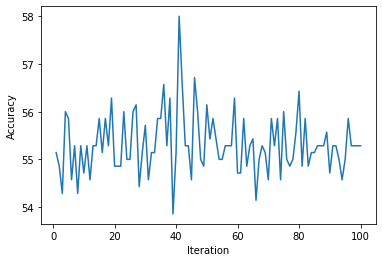

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(count,y)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

In [33]:
training = (max(fit)/cc)*100
print("TrainAcc : " + str(training))

TrainAcc : [55.28571429]


In [34]:
index = np.where(fit==max(fit))[0][0]
final_weight = weight[index]
final_weight

array([-203., -519., -465., -100.,  258.,  367., -616.])

In [35]:
def test(weight,mat_test_nor, row_choice_test,n,m,mat_all,mat_test):
  y = 0
  for j in range(n):
    if (np.sum(weight[:6]*mat_test_nor[j] )+weight [6])>=0:
      res_sigmoid = 1
    else:
      res_sigmoid = 0
    res_real = mat_all[row_choice[j]+1][0][1] - mat_test[j][1]
    
    if res_real >=0:
      res_real_sigmoid = 1
    else:
      res_real_sigmoid = 0
    if res_real_sigmoid ==res_sigmoid:
      y = y+1
  return y


In [36]:
g = 150
row_choice_test = np.random.randint(1000, 1400, (g, 1) )
data_test = get_training_data(data, row_choice_test,g)
data_test_norm = get_normalised_data(data_test, g, f-1)
testing = test(final_weight, data_test_norm, row_choice_test,g,f,data,data_test)
testing = (testing/g)*100
print("TESTING ACCURACY: "+str(testing))


TESTING ACCURACY: 67.33333333333333
